# Employee Flight Risk Modelling

### Introduction

Predicting employee flight (also known as Attrition or Churn) is a principal concern of Human Resource departments as it is typically very costly to replace employees. According to 
[this article](https://www.peoplekeep.com/blog/bid/312123/employee-retention-the-real-cost-of-losing-an-employee), 
the average cost to replace an employee is <i>"20 percent of annual salary for midrange positions (earning $\$$30,000 to $\$$50,000 a year). For example, the cost to replace a 40k manager would be $\$$8,000."</i> according to one study. Using the dataset which has fictional employee data along with 
attrition I attempted to determine which factors can help predict employee flight. I found it very 
challenging as the data is significantly imbalanced (only 16% of employees left) and also has quite
a few features (49 columns once processed). ***Results TBD***

This is a fictional dataset created by IBM Data Scientists which can be found on 
[Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset). 
It holds 1470 employee records with various HR factors, such as compensation, demographics, 
measures of environmental satisfaction, performance, work experience, and more along with whether 
the employee left the company or not.

Let's start by loading the data set...

## Imports and data load

In [13]:
# imports
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
sns.set(style='darkgrid')
%matplotlib notebook

# Load the data
df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

## Preliminary Data Exploration

Start with a profile report

C:\ProgramData\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


<IPython.core.display.Javascript object>


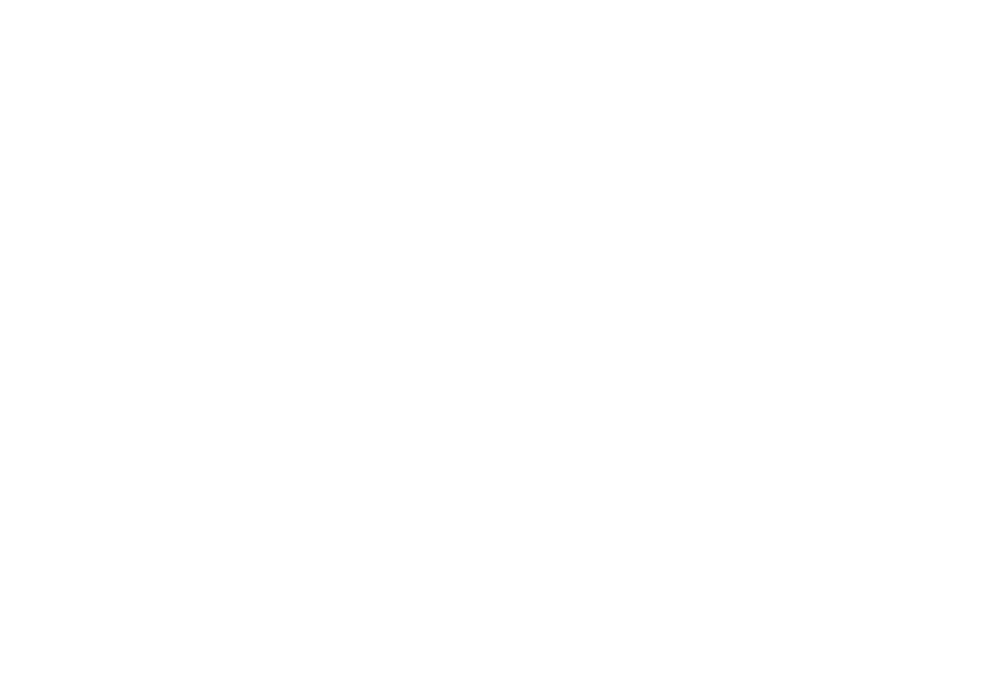

<IPython.core.display.Javascript object>


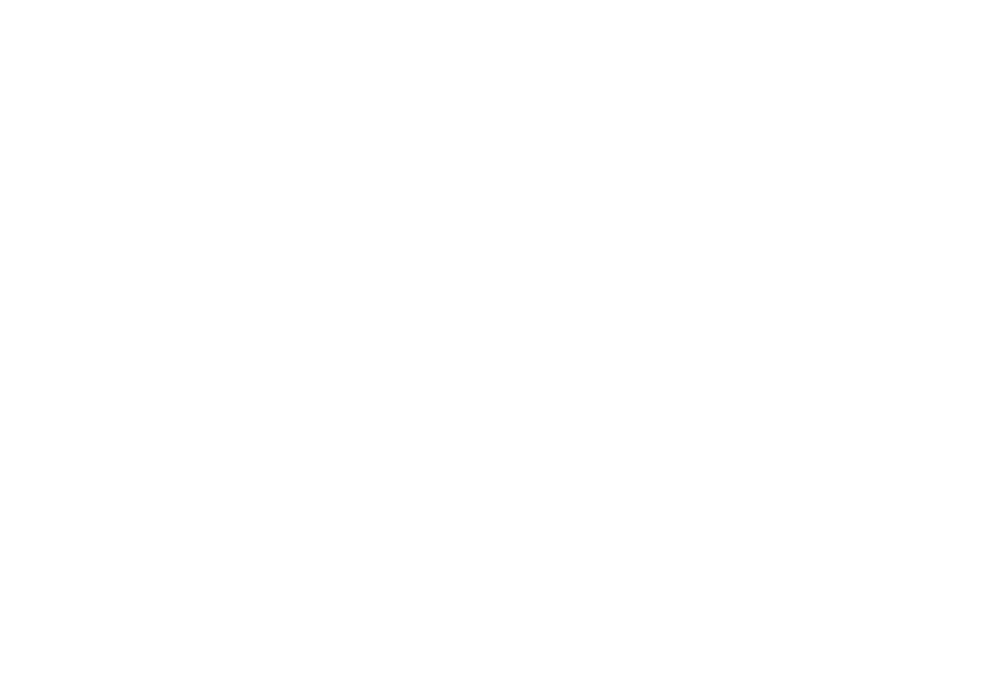

In [2]:
pandas_profiling.ProfileReport(df)

The Profiling report indicates a high correlation between MonthlyIncome and JobLevel so will drop JobLevel.

It also shows that three variables, EmployeeCount, StandardHours, and Over18, have a constant value which will also be dropped.

Finally, EmployeeNumber has 100% unique values which are really just an employee identifier which gives 0 explanatory power so will drop as well.

In [14]:
# drop irrelevant columns
df.drop(['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18', 'JobLevel'], axis=1, inplace=True)

There are four variables that appear to represent employee compensation, DailyRate, HourlyRate, MonthlyRate, MonthlyIncome. I want to know if they are basically linear functions of one another which would make them redundant. I also want to see how they compare to the target variable "Attrition".

<IPython.core.display.Javascript object>


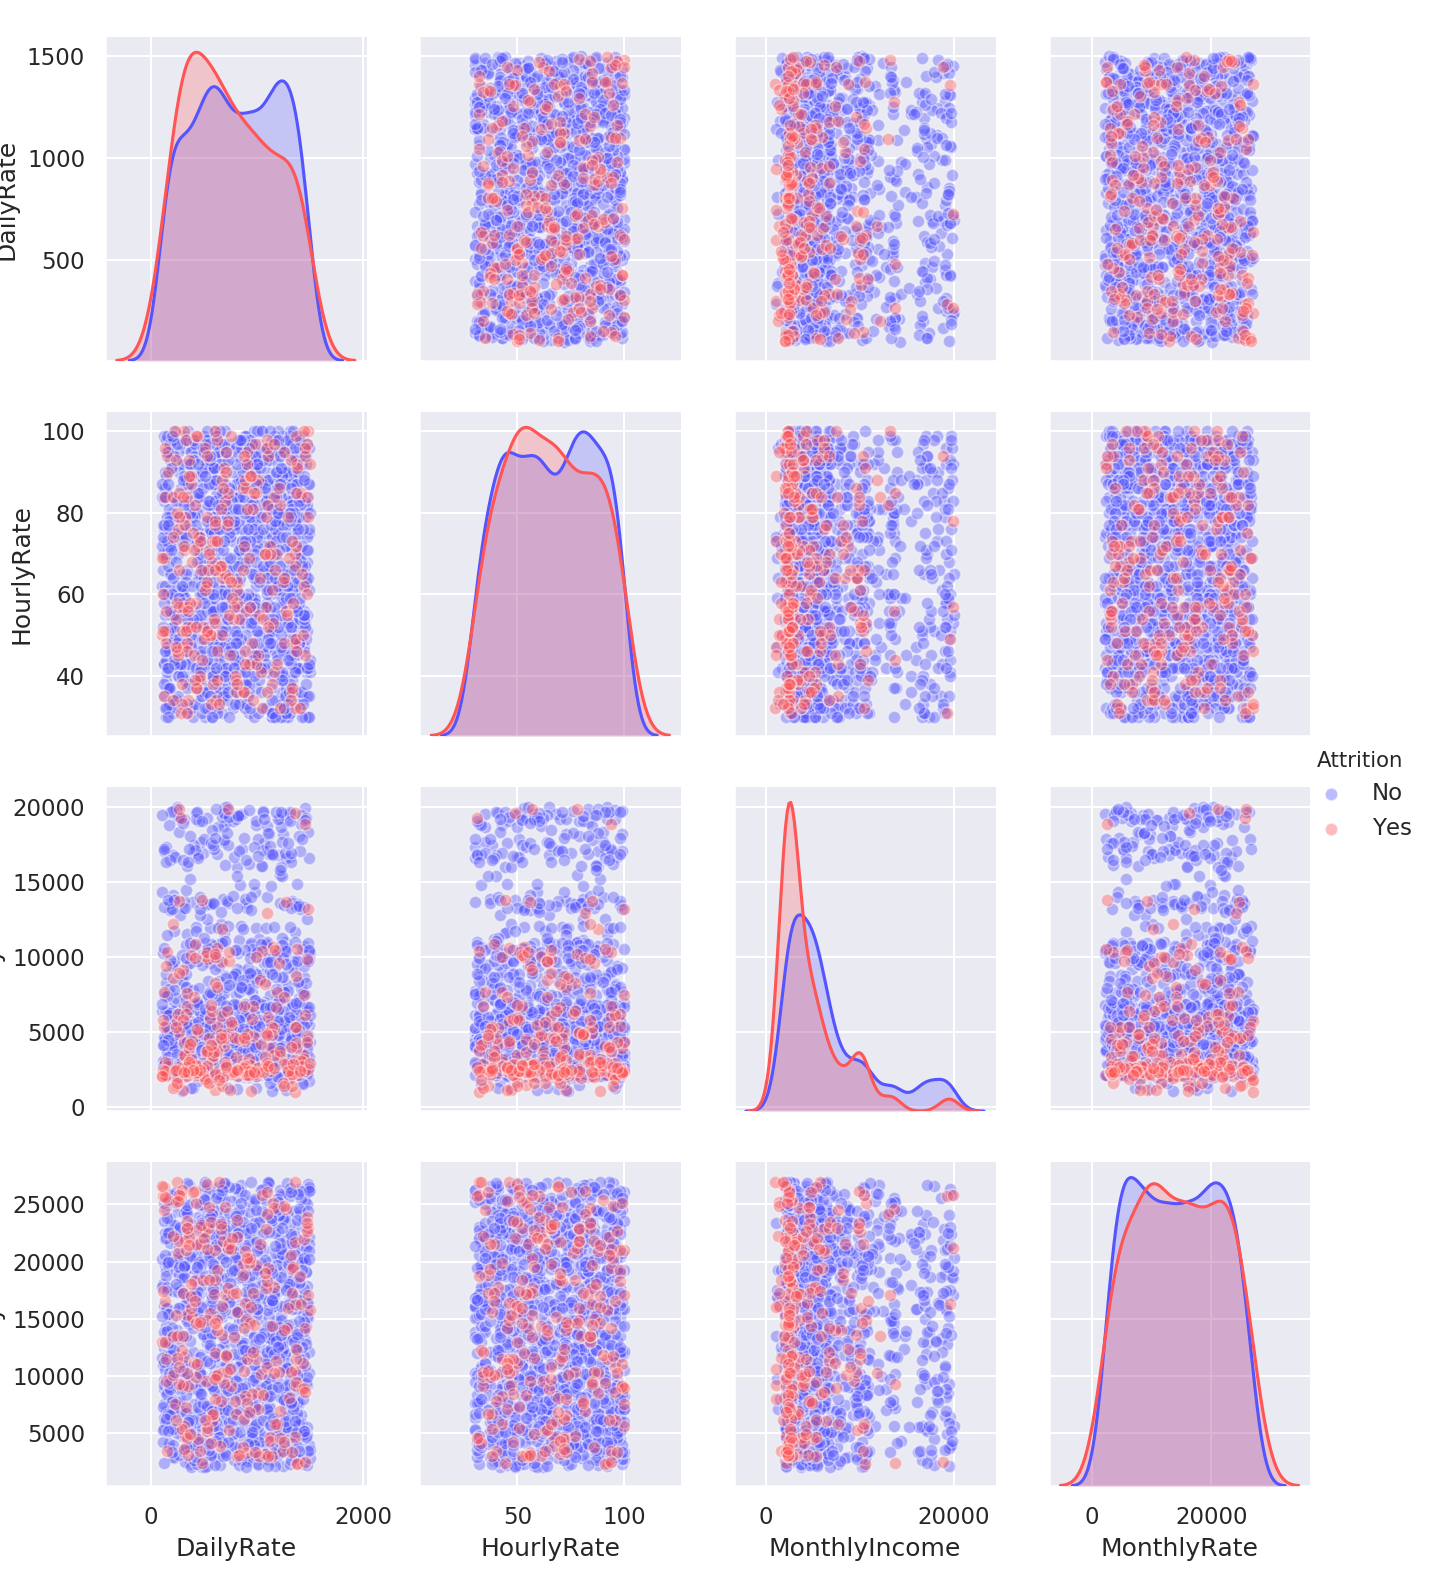

In [104]:
# what difference if any between all the different rate fields?
cols = ['DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate','Attrition']
g = sns.pairplot(df[cols], hue='Attrition', hue_order=['No', 'Yes'], palette='seismic', 
                 diag_kind='kde', plot_kws={'alpha':0.4})

In [105]:
# Correlations
cols = ['DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate']
df[cols].corr()

DailyRate  HourlyRate  MonthlyIncome  MonthlyRate
DailyRate       1.000000    0.023381       0.007707    -0.032182
HourlyRate      0.023381    1.000000      -0.015794    -0.015297
MonthlyIncome   0.007707   -0.015794       1.000000     0.034814
MonthlyRate    -0.032182   -0.015297       0.034814     1.000000

So they are not very correlated with each other at all which confuses me because there was no description of these in the Kaggle data description so not really sure what these are.
What I can see on the diagonal kde plots is that MonthlyIncome and DailyRate seem to be the ones that are more correlated with Attrition. MonthlyRate is not really correlated with Attrition.

### More visualizations:



In [106]:
# Helper function
def numerical(column):
    """
    Returns a df column with string values replaced as integer values to be used in plots.
    """
    int_labels = column.unique().tolist()
    mapping = dict(zip(int_labels, range(1, len(int_labels) + 1)))
    mapping['Yes'] = 1
    mapping['No'] = 0
    mapping['yes'] = 1
    mapping['no'] = 0
    mapping['YES'] = 1
    mapping['NO'] = 0
    mapping['y'] = 1
    mapping['n'] = 0
    mapping['Y'] = 1
    mapping['N'] = 0

    return column.replace(mapping)

# get numerical versions of string columns
for col in df:
    if df[col].dtype == object:
        df[f'{col}_numerical'] = numerical(df[col])

#### Various distributions with Attrition as hue

<IPython.core.display.Javascript object>


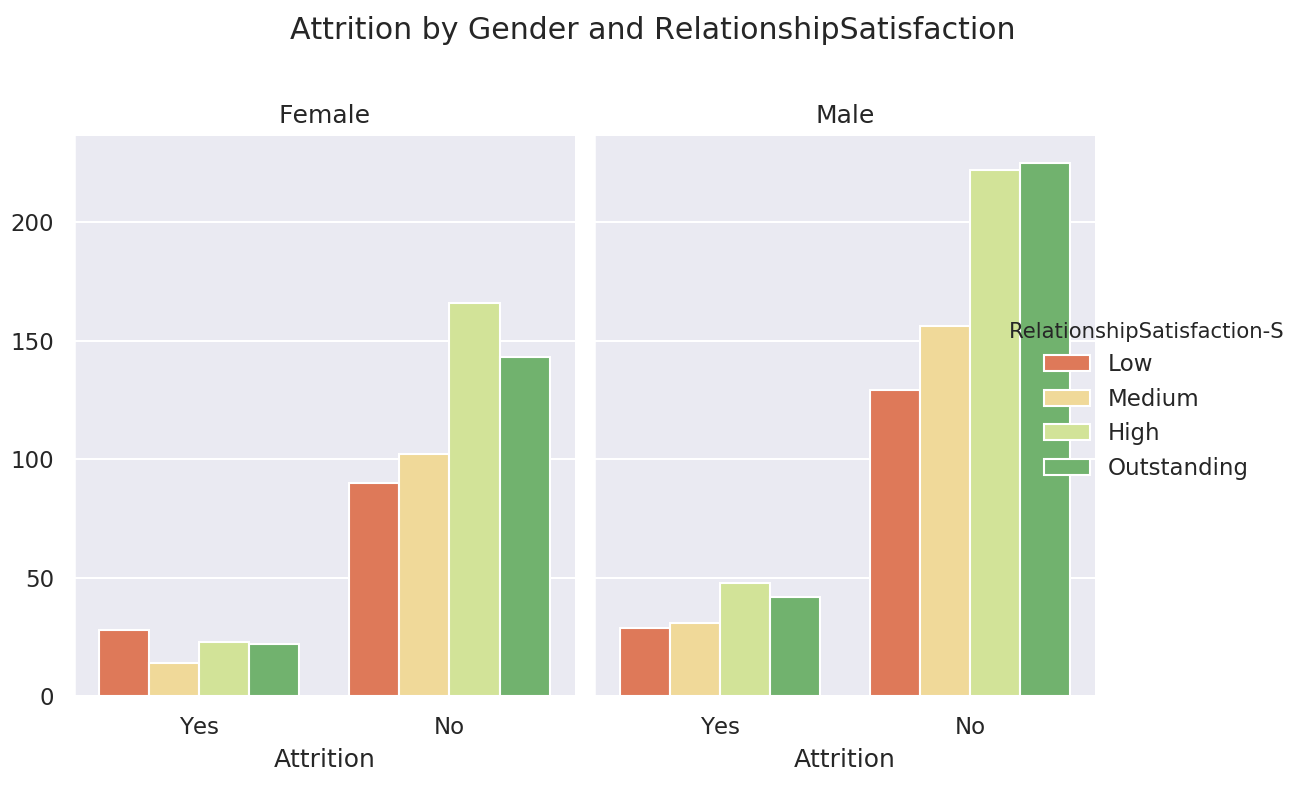

<IPython.core.display.Javascript object>


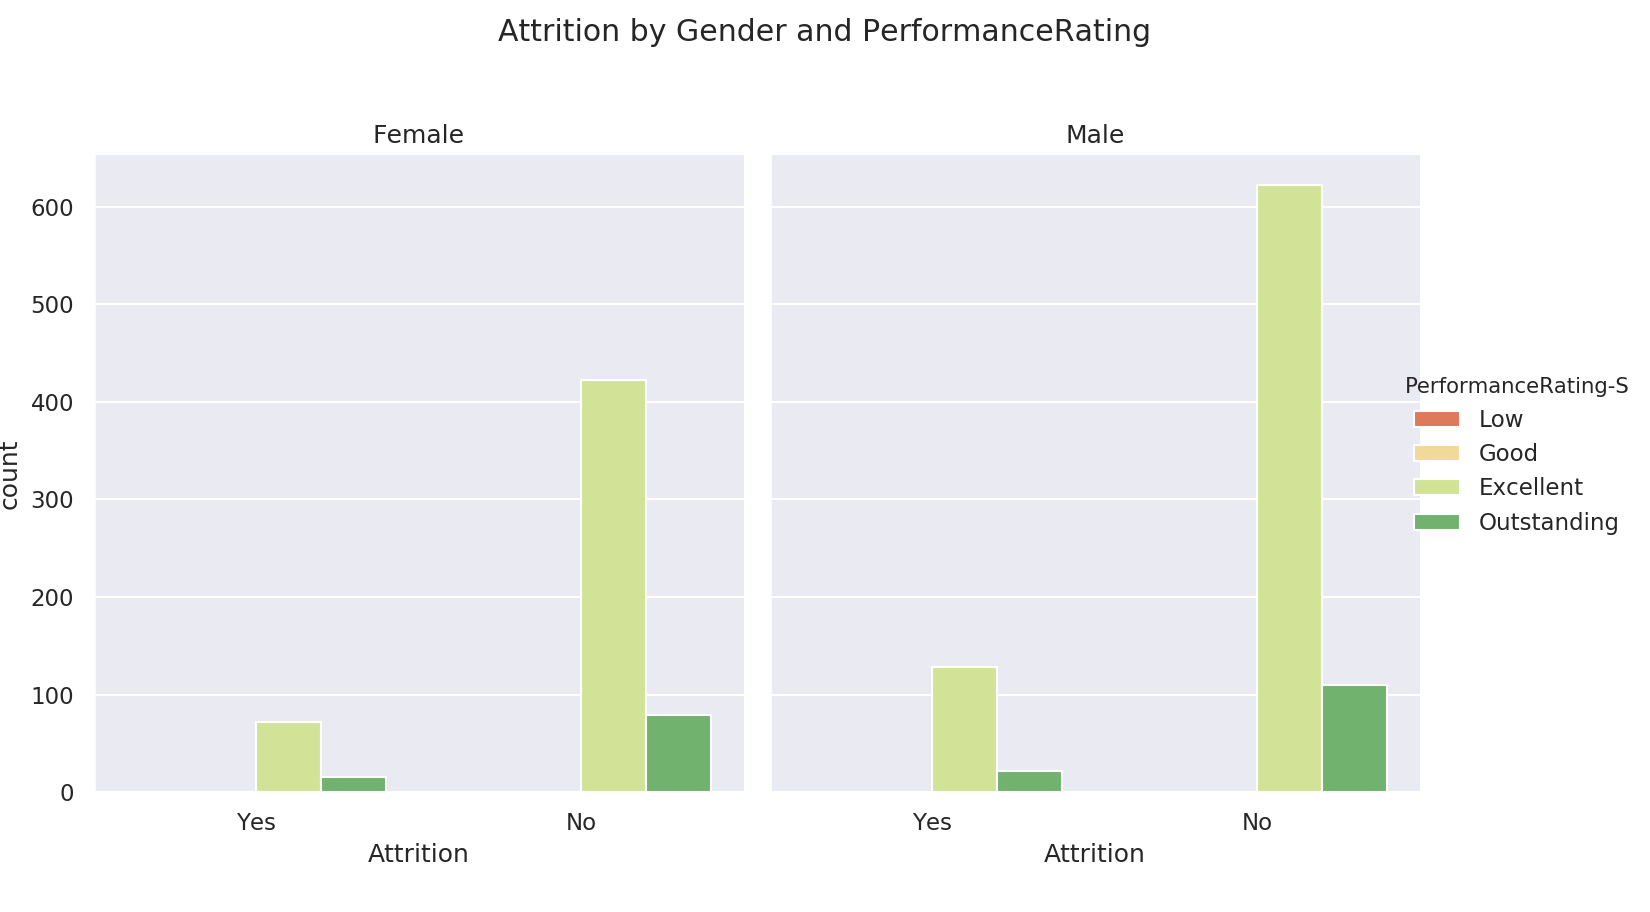

In [107]:
# get RelationshipSatisfaction with string names for levels
df['RelationshipSatisfaction-S'] = df['RelationshipSatisfaction'].map({1: 'Low', 2: 'Medium',
                                                                       3: 'High', 4: 'Outstanding'})

# actual plot
g = sns.catplot(x='Attrition', data=df,
                hue='RelationshipSatisfaction-S',
                col='Gender',
                palette=sns.color_palette("RdYlGn", 4),
                hue_order=['Low', 'Medium', 'High', 'Outstanding'],
                kind='count')
plt.subplots_adjust(top=0.83)
g.set_titles("{col_name}")
g.fig.suptitle('Attrition by Gender and RelationshipSatisfaction')

# Next distribution of Attrition by by Gender and PerformanceRating
df['PerformanceRating-S'] = df['PerformanceRating'].map({1: 'Low', 2: 'Good',
                                                         3: 'Excellent', 4: 'Outstanding'})
g = sns.catplot(x='Attrition', data=df,
                hue='PerformanceRating-S',
                col='Gender',
                palette=sns.color_palette("RdYlGn", 4),
                hue_order=['Low', 'Good', 'Excellent', 'Outstanding'],
                kind='count')
plt.subplots_adjust(top=0.83)
g.set_titles("{col_name}")
g.fig.suptitle('Attrition by Gender and PerformanceRating')

# drop label columns
df.drop(['PerformanceRating-S', 'RelationshipSatisfaction-S'], axis='columns', inplace=True)

<IPython.core.display.Javascript object>


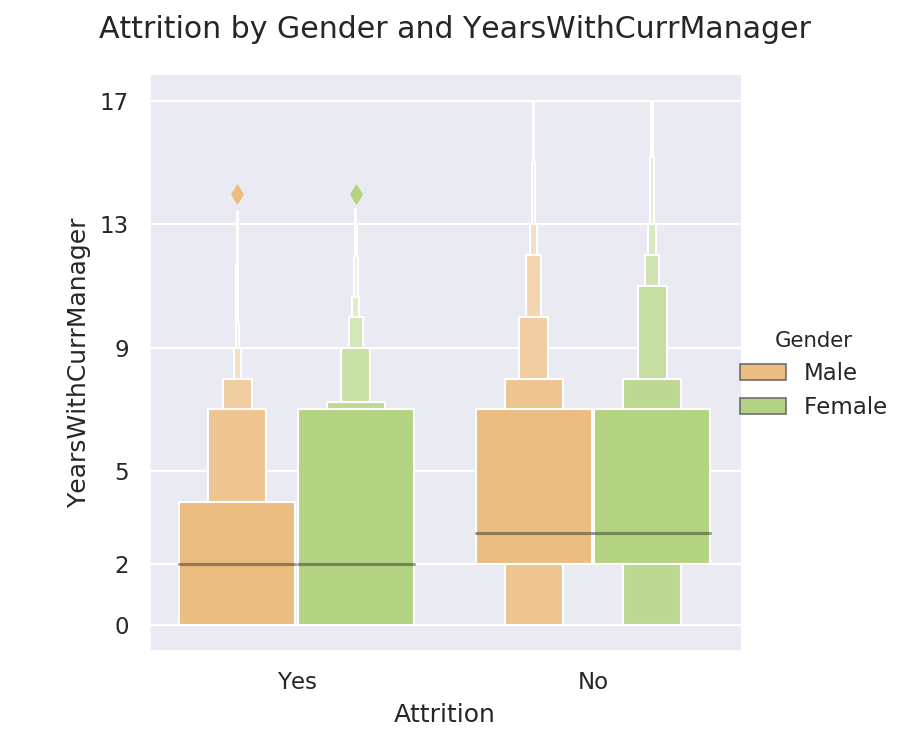

<IPython.core.display.Javascript object>


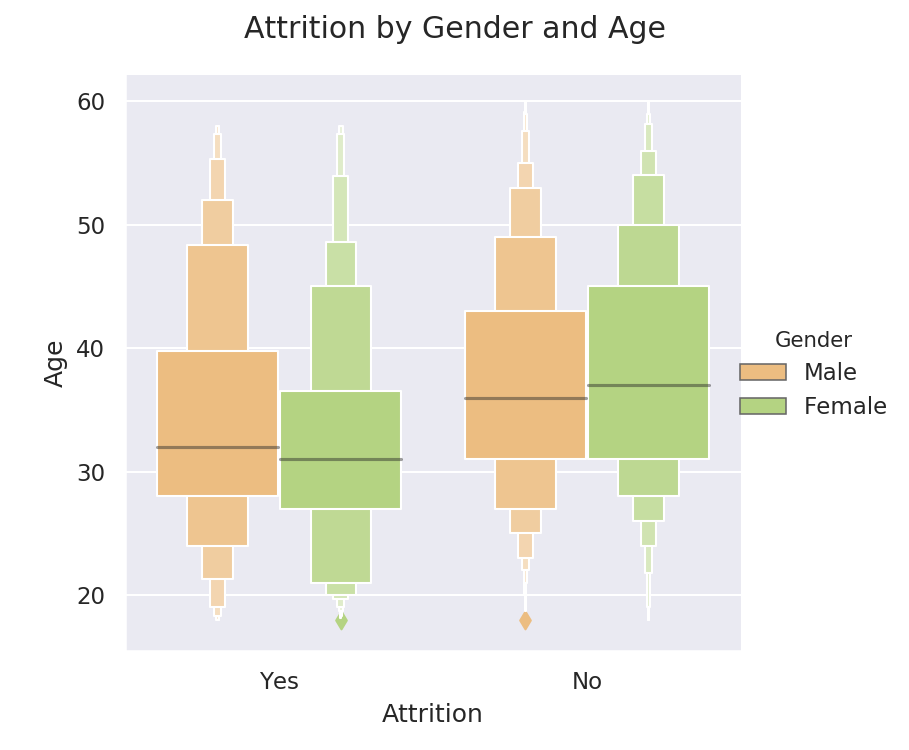

Text(0.5, 0.98, 'Attrition by Gender and Age')

In [108]:
# Next, boxen plot of Attrition by Gender and YearsWithCurrManager
g = sns.catplot(x='Attrition', y='YearsWithCurrManager', data=df,
                hue='Gender',
                hue_order=['Male', 'Female'],
                palette=sns.color_palette("RdYlGn", 2),
                kind='boxen')
plt.yticks([0., 2., 5., 9., 13., 17.])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Attrition by Gender and YearsWithCurrManager')

# Next, boxen plot of Attrition by Gender and Age
g = sns.catplot(x='Attrition', y='Age', data=df,
                hue='Gender',
                hue_order=['Male', 'Female'],
                palette=sns.color_palette("RdYlGn", 2),
                kind='boxen')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Attrition by Gender and Age')

Let's compare total work experience with the various compensation variables.

<IPython.core.display.Javascript object>


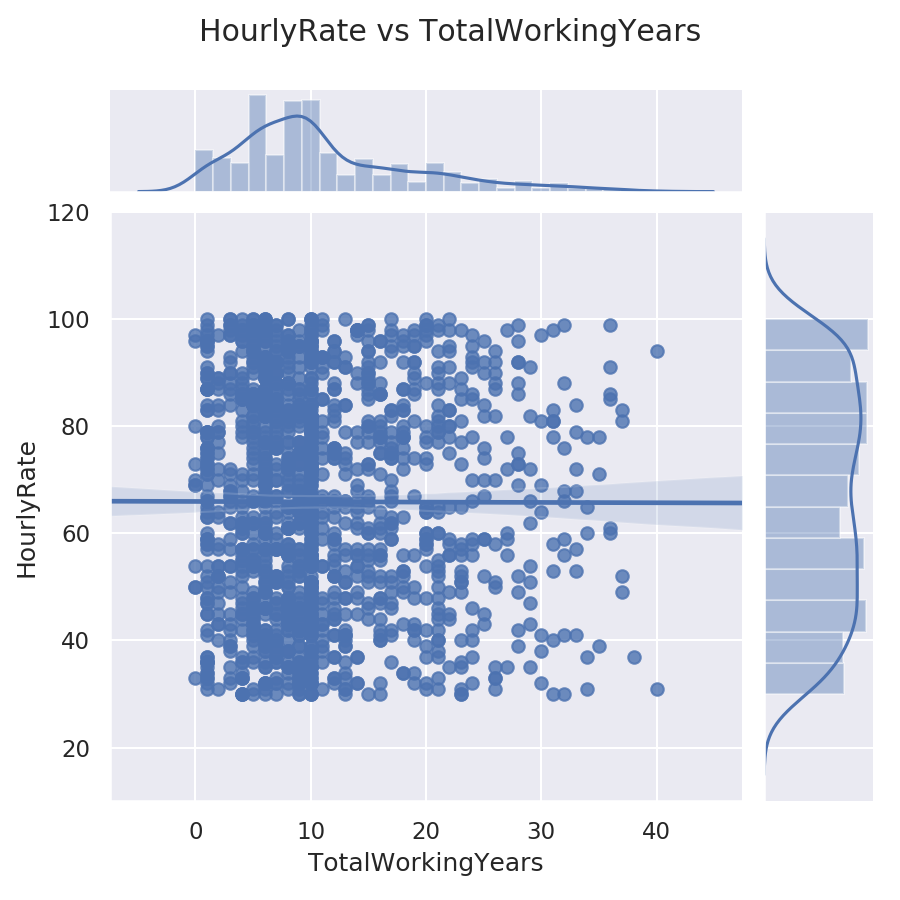

<IPython.core.display.Javascript object>


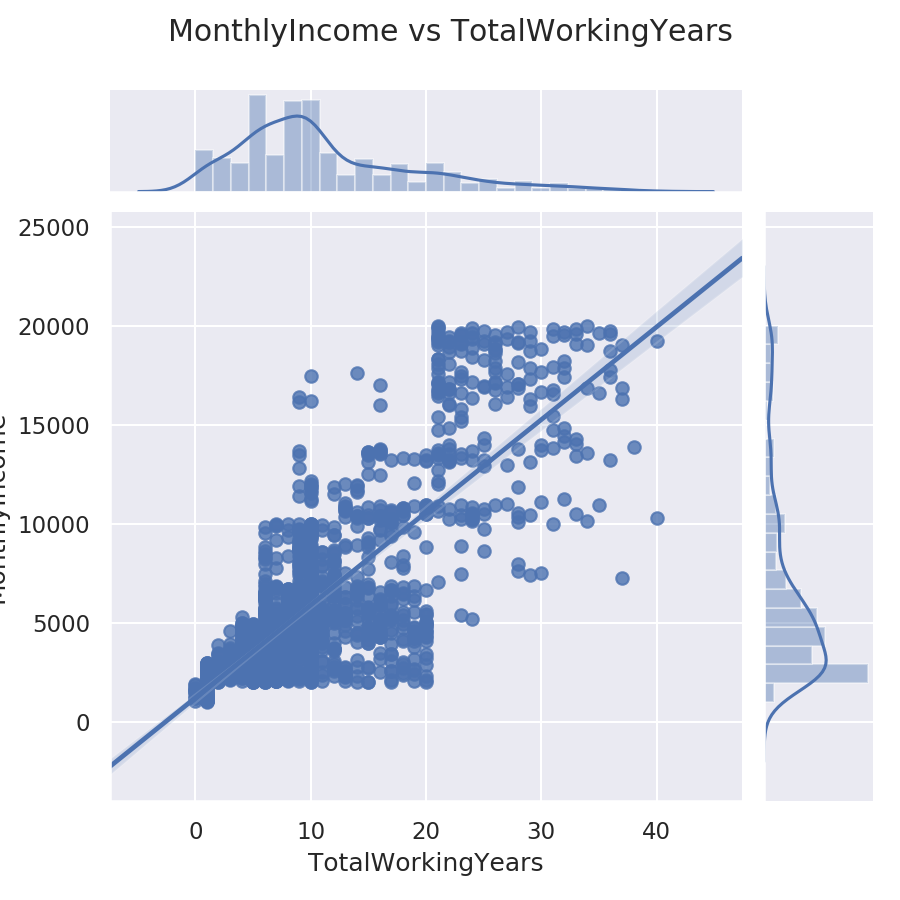

<IPython.core.display.Javascript object>


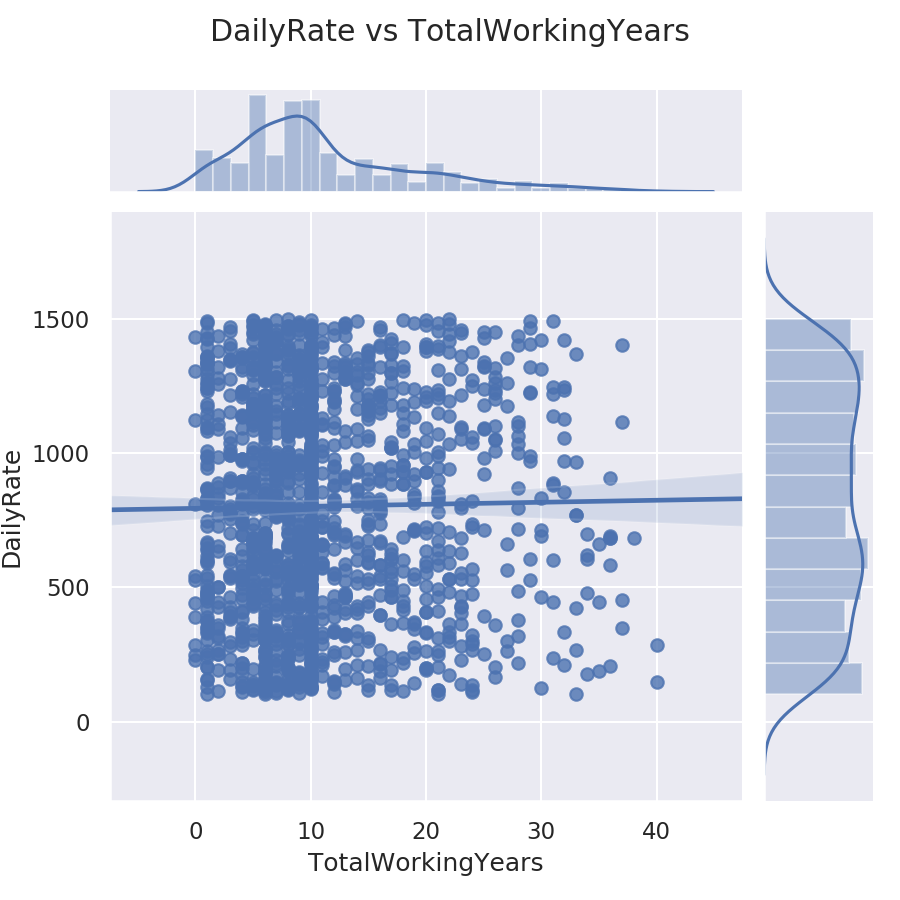

<IPython.core.display.Javascript object>


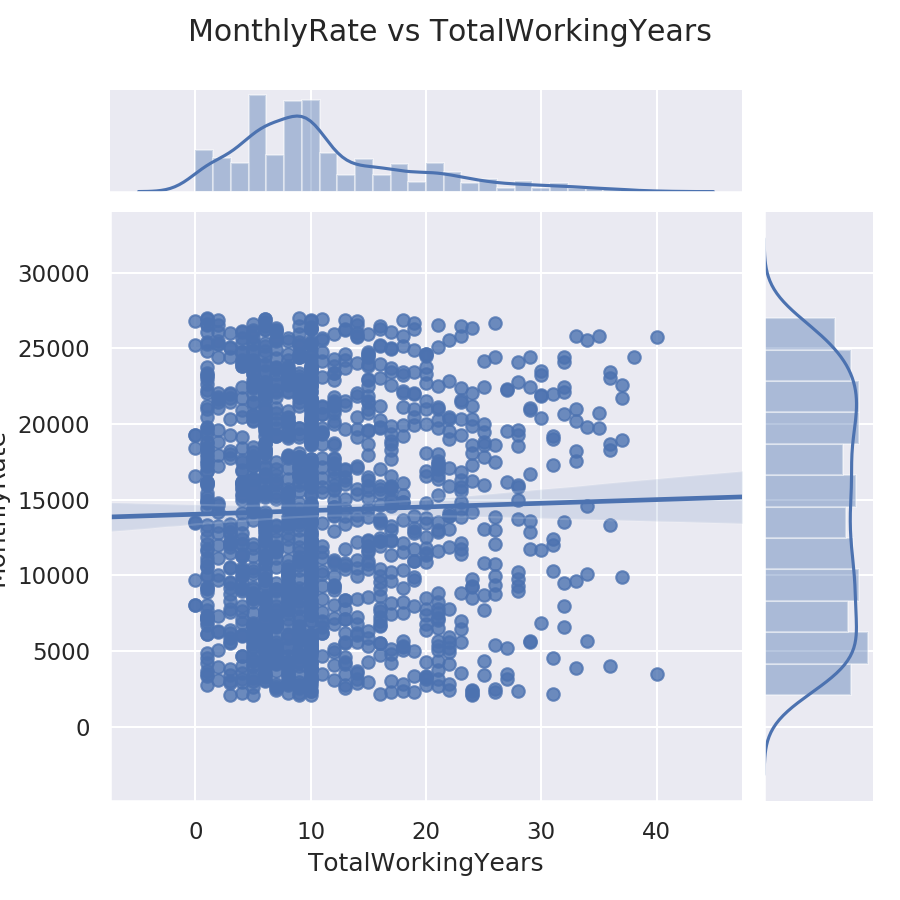

Text(0.5, 0.98, 'MonthlyRate vs TotalWorkingYears')

In [109]:
# Jointplot of HourlyRate and TotalWorkingYears
g = sns.jointplot(x='TotalWorkingYears', y='HourlyRate', data=df, kind='reg', )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('HourlyRate vs TotalWorkingYears')

# Jointplot of MonthlyIncome and TotalWorkingYears
g = sns.jointplot(x='TotalWorkingYears', y='MonthlyIncome', data=df, kind='reg', )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('MonthlyIncome vs TotalWorkingYears')

# Jointplot of DailyRate and TotalWorkingYears
g = sns.jointplot(x='TotalWorkingYears', y='DailyRate', data=df, kind='reg', )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('DailyRate vs TotalWorkingYears')

# Jointplot of MonthlyRate and TotalWorkingYears
g = sns.jointplot(x='TotalWorkingYears', y='MonthlyRate', data=df, kind='reg', )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('MonthlyRate vs TotalWorkingYears')

Only MonthlyIncome seems to vary with total working experience which seems to indicate this is the only variable that actually represents each employee's income.

Let's look at Attrition by MonthlyIncome and Age and we will also add a categorical variable like OverTime

<IPython.core.display.Javascript object>


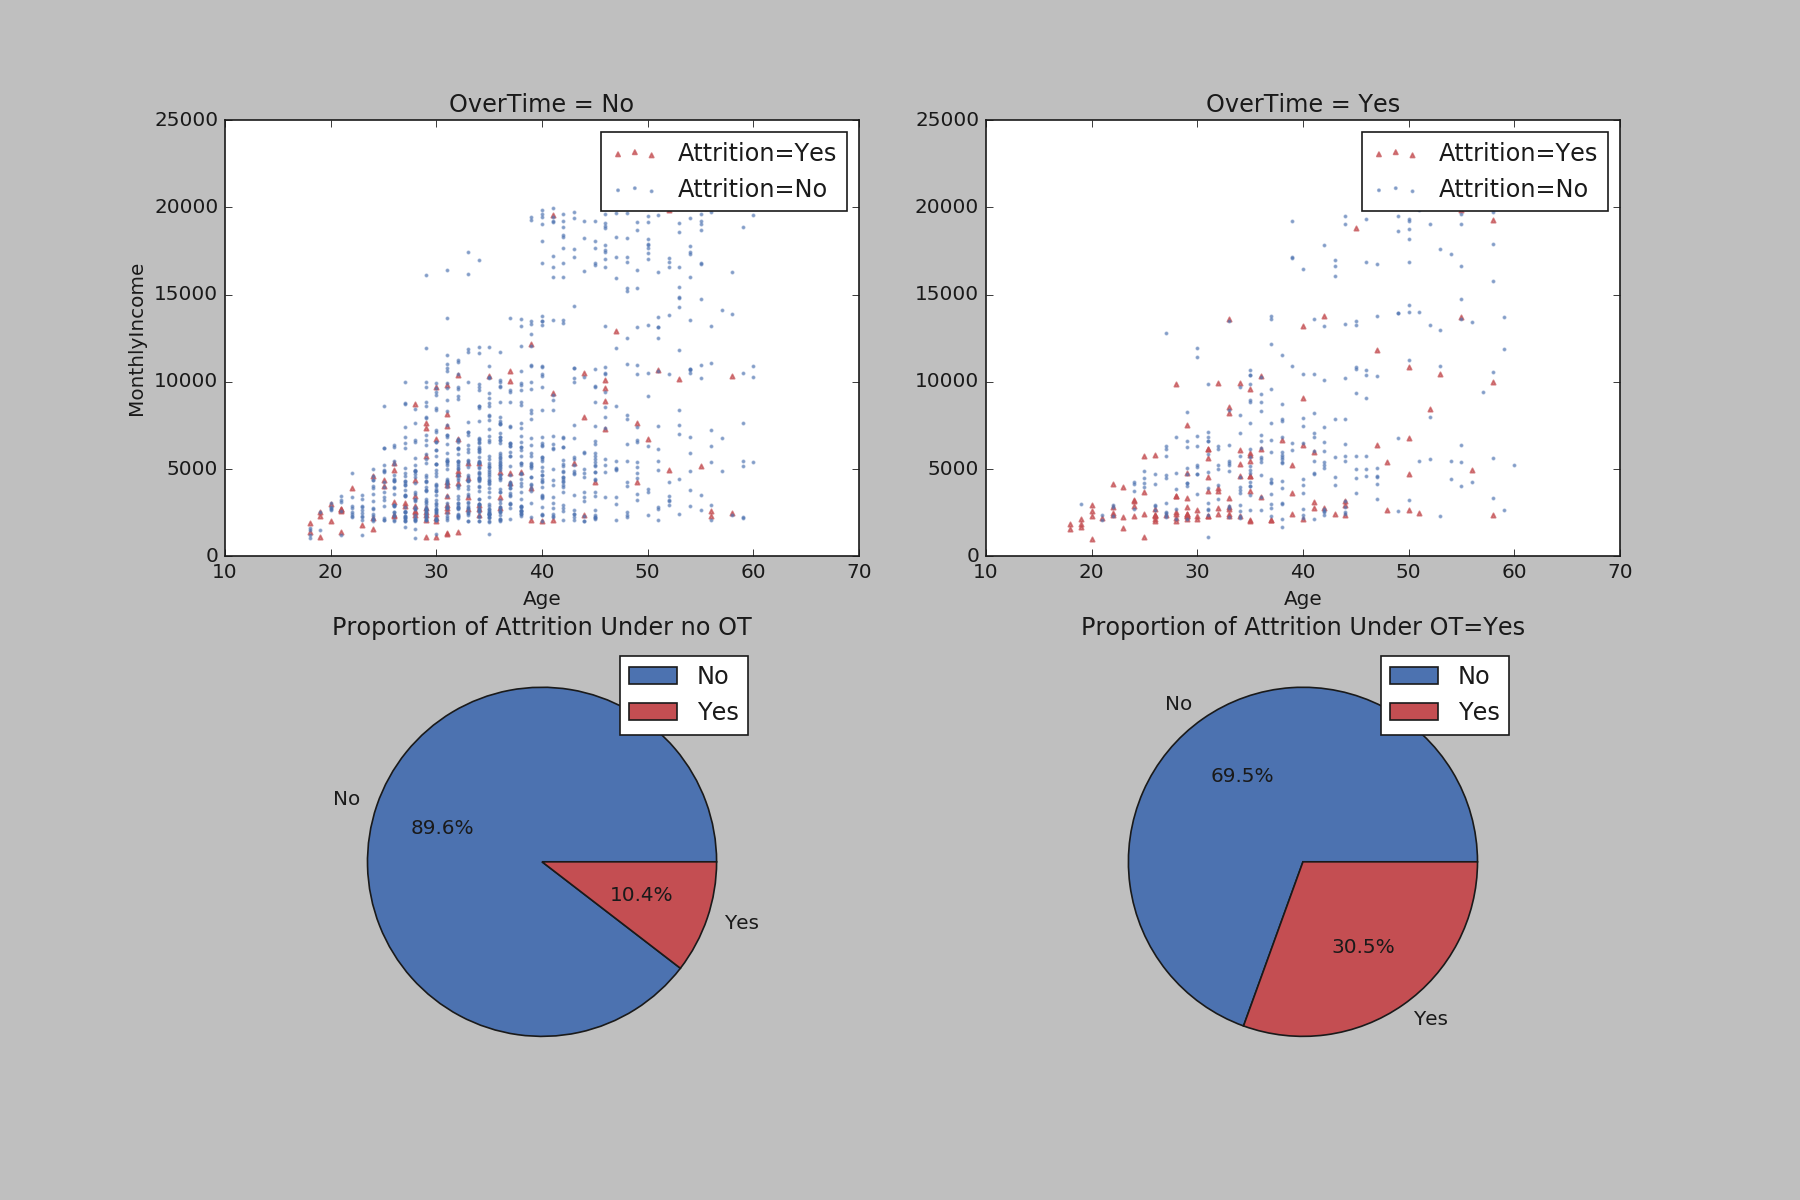

In [3]:
# Attrition by monthly income, OverTime, and Age
plt.style.use('classic')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# will use matplotlib here so got to prepare some dataframes for plotting
attr_no = df['Attrition'] == 'No'
attr_yes = df['Attrition'] == 'Yes'
ot_no = df['OverTime'] == 'No'
ot_yes = df['OverTime'] == 'Yes'
df_0_0 = df[attr_no & ot_no]
df_0_1 = df[attr_no & ot_yes]
df_1_0 = df[attr_yes & ot_no]
df_1_1 = df[attr_yes & ot_yes]

axes[0][0].scatter(df_1_0['Age'], df_1_0['MonthlyIncome'], s=7, color='r', marker='^', alpha=0.7,
                   label='Attrition=Yes')
axes[0][0].set_title('OverTime = No')
axes[0][0].set_xlabel('Age')
axes[0][0].set_ylabel('MonthlyIncome')
axes[0][0].scatter(df_0_0['Age'], df_0_0['MonthlyIncome'], s=2, color='b', marker='o', alpha=0.5,
                   label='Attrition=No')
axes[0][0].legend()

axes[0][1].scatter(df_1_1['Age'], df_1_1['MonthlyIncome'], s=7, color='r', marker='^', alpha=0.7,
                   label='Attrition=Yes')
axes[0][1].set_title('OverTime = Yes')
axes[0][1].set_xlabel('Age')
axes[0][1].scatter(df_0_1['Age'], df_0_1['MonthlyIncome'], s=2, color='b', marker='o', alpha=0.5,
                   label='Attrition=No')
axes[0][1].legend()

# Pie charts for OverTime
df__0 = df[ot_no]
df__1 = df[ot_yes]

axes[1][0].pie(df__0['Attrition'].value_counts(),
               labels=df__0['Attrition'].value_counts().index.tolist(),
               autopct='%1.1f%%', colors=['b', 'r'])
axes[1][0].set_title('Proportion of Attrition Under no OT')
axes[1][0].legend()
axes[1][1].pie(df__1['Attrition'].value_counts(),
               labels=df__1['Attrition'].value_counts().index.tolist(),
               autopct='%1.1f%%', colors=['b', 'r'])
axes[1][1].set_title('Proportion of Attrition Under OT=Yes')
axes[1][1].legend()

Those who left the company have a much higher OverTime than those who did not. Also there seems to be a cluster of younger, low-income employees who are at higher risk of leaving. I say that just by looking at the scatter plot but later I would like to apply a k-means clustering model to see if that is really right.

After exploring the data, I would like to get a better understanding by running the data through different ML models. However, the data is not suitable for this in its current form so we must pre-process the data.

## Pre-processing


Now begin preparing the data before applying ml models.

At a high level, this involves:
1. Dropping numerical columns used for plotting
2. Encoding Target column with pandas.get_dummies()
3. One-hot encoding the nominal features using sklearn.OneHotEncoder
4. Scale all features to lie between $[0, 1]$

#### 1. Dropping numerical columns used for plotting

In [11]:
df.drop(['Attrition_numerical', 
         'BusinessTravel_numerical',
         'Department_numerical',
         'EducationField_numerical',
         'Gender_numerical',
         'JobRole_numerical',
         'MaritalStatus_numerical',
         'OverTime_numerical'], axis='columns', inplace=True)


#### 2. Encoding Target column with pandas.get_dummies()

In [15]:
Attrition_enc = pd.get_dummies(df['Attrition'], drop_first=True)
Attrition_enc.columns = ['Attrition-enc']


#### 3. One-hot encoding the nominal features using sklearn.OneHotEncoder

First separate the target and feature matrix

In [39]:
X = df.drop('Attrition', axis='columns')
y = Attrition_enc['Attrition-enc']
print(X.shape)
print(y.shape)

(1470, 29)
(1470,)


Now apply OneHotEncoder to the nominal columns using ColumnTransformer

In [40]:
# get nominal categorical columns in list
cat_cols = X.columns[X.dtypes==object].tolist()

# set up the ColumnTransformer and OneHotEncoder
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse=False, drop='first'), cat_cols)],
    remainder='passthrough'
)

# set up column names for dummy columns which will be used when we create a new X dataframe
dummies =   ['BusinessTravel_Travel_Frequently',
             'BusinessTravel_Travel_Rarely',
             'Department_Research & Development',
             'Department_Sales',
             'EducationField_Life Sciences',
             'EducationField_Marketing',
             'EducationField_Medical',
             'EducationField_Other',
             'EducationField_Technical Degree',
             'Gender_Female',
             'JobRole_Human Resources',
             'JobRole_Laboratory Technician',
             'JobRole_Manager',
             'JobRole_Manufacturing Director',
             'JobRole_Research Director',
             'JobRole_Research Scientist',
             'JobRole_Sales Executive',
             'JobRole_Sales Representative',
             'MaritalStatus_Married',
             'MaritalStatus_Single',
             'OverTime_Yes']

# Now let's get the full column list by appending dummies to the original columns list of X minus the categorical 
# columns themselves (since we are going to use one-hot-encoded columns instead)
new_cols = dummies + list(X.columns)
new_cols = [e for e in new_cols if e not in cat_cols]

# now we apply the ColumnTransformer to X and create a new dataframe
X = pd.DataFrame(ct.fit_transform(X), columns=new_cols)

X.describe()

BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  \
count                       1470.000000                   1470.000000   
mean                           0.188435                      0.709524   
std                            0.391193                      0.454137   
min                            0.000000                      0.000000   
25%                            0.000000                      0.000000   
50%                            0.000000                      1.000000   
75%                            0.000000                      1.000000   
max                            1.000000                      1.000000   

       Department_Research & Development  Department_Sales  \
count                        1470.000000       1470.000000   
mean                            0.653741          0.303401   
std                             0.475939          0.459884   
min                             0.000000          0.000000   
25%                             0.000000          0.000000   
50%                             1.000000          0.000000   
75%                             1.000000          1.000000   
max                             1.000000          1.000000   

       EducationField_Life Sciences  EducationField_Marketing  \
count                   1470.000000               1470.000000   
mean                       0.412245                  0.108163   
std                        0.492406                  0.310692   
min                        0.000000                  0.000000   
25%                        0.000000                  0.000000   
50%                        0.000000                  0.000000   
75%                        1.000000                  0.000000   
max                        1.000000                  1.000000   

       EducationField_Medical  EducationField_Other  \
count             1470.000000           1470.000000   
mean                 0.315646              0.055782   
std                  0.464931              0.229579   
min                  0.000000              0.000000   
25%                  0.000000              0.000000   
50%                  0.000000              0.000000   
75%                  1.000000              0.000000   
max                  1.000000              1.000000   

       EducationField_Technical Degree  Gender_Female  ...  PerformanceRating  \
count                      1470.000000    1470.000000  ...        1470.000000   
mean                          0.089796       0.600000  ...           3.153741   
std                           0.285986       0.490065  ...           0.360824   
min                           0.000000       0.000000  ...           3.000000   
25%                           0.000000       0.000000  ...           3.000000   
50%                           0.000000       1.000000  ...           3.000000   
75%                           0.000000       1.000000  ...           3.000000   
max                           1.000000       1.000000  ...           4.000000   

       RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
count               1470.000000       1470.000000        1470.000000   
mean                   2.712245          0.793878          11.279592   
std                    1.081209          0.852077           7.780782   
min                    1.000000          0.000000           0.000000   
25%                    2.000000          0.000000           6.000000   
50%                    3.000000          1.000000          10.000000   
75%                    4.000000          1.000000          15.000000   
max                    4.000000          3.000000          40.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count            1470.000000      1470.000000     1470.000000   
mean                2.799320         2.761224        7.008163   
std                 1.289271         0.706476        6.126525   
min                 0.000000         1.000000        0.000000   
25% 

Let's take a look at the newly transformed dataframe with pandas_profiling

In [37]:
pandas_profiling.ProfileReport(X)

TypeError: concat() got an unexpected keyword argument 'join_axes'

~~The report states that JobRole_Human Resources which is a Job Title is highly correlated with Department_Human Resources which is a department so we will drop it.~~ I already dropped it above after drop='First' for OneHotEncoder

In [41]:
# X.pop('JobRole_Human Resources')

# # also remove this column from the dummies list in case we need to use the later
# dummies.remove('JobRole_Human Resources')

# print(X.columns[13:23])
# dummies

#### 4. Scale all features to lie between \[0, 1]

We know the dummy features are nominal and are either 0 or 1 already so we do not need to normalize them. 
However, all other features including the ordinal categorical variables will be scaled to lie in the interval $[0, 1]$

In [8]:
# need to get indices for each column for code below (TODO: find a more elegant way to do this)
columns_wIndex = list(zip(range(len(X.columns)), list(X.columns) ))
columns_wIndex

[(0, 'BusinessTravel_Non-Travel'),
 (1, 'BusinessTravel_Travel_Frequently'),
 (2, 'BusinessTravel_Travel_Rarely'),
 (3, 'Department_Human Resources'),
 (4, 'Department_Research & Development'),
 (5, 'Department_Sales'),
 (6, 'EducationField_Human Resources'),
 (7, 'EducationField_Life Sciences'),
 (8, 'EducationField_Marketing'),
 (9, 'EducationField_Medical'),
 (10, 'EducationField_Other'),
 (11, 'EducationField_Technical Degree'),
 (12, 'Gender_Female'),
 (13, 'Gender_Male'),
 (14, 'JobRole_Healthcare Representative'),
 (15, 'JobRole_Human Resources'),
 (16, 'JobRole_Laboratory Technician'),
 (17, 'JobRole_Manager'),
 (18, 'JobRole_Manufacturing Director'),
 (19, 'JobRole_Research Director'),
 (20, 'JobRole_Research Scientist'),
 (21, 'JobRole_Sales Executive'),
 (22, 'JobRole_Sales Representative'),
 (23, 'MaritalStatus_Divorced'),
 (24, 'MaritalStatus_Married'),
 (25, 'MaritalStatus_Single'),
 (26, 'OverTime_No'),
 (27, 'OverTime_Yes'),
 (28, 'Age'),
 (29, 'DailyRate'),
 (30, 'Dist

Get all non-dummy columns

In [42]:
cols_non_dummy = [col for col in list(X.columns) if col not in dummies]
cols_non_dummy

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

We can scale the data to lie in $[0, 1]$ using SciKitLearn's MinMaxScaler. The documentation states:

> Transform features by scaling each feature to a given range.
> 
> This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
> 

So basically the transformation for each value $val$ in each column $col$ of $X$ is: 

$$
val_{Transformed} = \frac{val - min(col)}{max(col) - min(col)}
$$

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X[cols_non_dummy])
X_scaled = pd.DataFrame(scaler.transform(X[cols_non_dummy]), columns=cols_non_dummy)

# Now get the rest of the X dataframe appended
X_scaled = pd.concat([X.drop(cols_non_dummy, axis=1), X_scaled], axis=1)


In [20]:
# just making sure I didn't f anything up :)
for col in X[cols_non_dummy]:
    print(f'{col}: min: {X[col].min()}   max: {X[col].max()}')
    print(f'Original: {sorted(X[col].head().unique())}')
    print(f'Scaled: {sorted(X_scaled[col].head().unique())}\n\n')

Age: min: 18.0   max: 60.0
Original: [27.0, 33.0, 37.0, 41.0, 49.0]
Scaled: [0.21428571428571425, 0.35714285714285715, 0.4523809523809524, 0.5476190476190477, 0.7380952380952379]


DailyRate: min: 102.0   max: 1499.0
Original: [279.0, 591.0, 1102.0, 1373.0, 1392.0]
Scaled: [0.12670007158196134, 0.35003579098067283, 0.7158196134574086, 0.9098067287043664, 0.9234073013600572]


DistanceFromHome: min: 1.0   max: 29.0
Original: [1.0, 2.0, 3.0, 8.0]
Scaled: [0.0, 0.03571428571428571, 0.07142857142857142, 0.25]


Education: min: 1.0   max: 5.0
Original: [1.0, 2.0, 4.0]
Scaled: [0.0, 0.25, 0.75]


EnvironmentSatisfaction: min: 1.0   max: 4.0
Original: [1.0, 2.0, 3.0, 4.0]
Scaled: [0.0, 0.3333333333333333, 0.6666666666666667, 1.0]


HourlyRate: min: 30.0   max: 100.0
Original: [40.0, 56.0, 61.0, 92.0, 94.0]
Scaled: [0.14285714285714285, 0.3714285714285714, 0.4428571428571429, 0.8857142857142857, 0.9142857142857141]


JobInvolvement: min: 1.0   max: 4.0
Original: [2.0, 3.0]
Scaled: [0.333333333

## Finally, some Machine Learning!

Let's just start with a straightforward logistic regression with the full feature non-scaled matrix X.

In [44]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=999)

In [45]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=9999)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9999,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
y_pred = lr.predict(X_test)

from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_recall_fscore_support
precision, recall, fbeta, support = precision_recall_fscore_support(y_test, y_pred)

print(f'f1-score: {f1_score(y_test, y_pred, average="binary"):.2f}')
print('\n')
print(f'Accuracy score is: {accuracy_score(y_test, y_pred):.2f}')
print(f'Null Accuracy: '
      f'{y.value_counts(normalize=True)[0]:.2f}\n\n')
print(f'Positive Recall: {recall[1]:.2f}')
print(f'Positive Precision: {precision[1]:.2f}\n\n')
print(f'Full report:\n{classification_report(y_test, y_pred)}\n')

f1-score: 0.46


Accuracy score is: 0.87
Null Accuracy: 0.84


Positive Recall: 0.33
Positive Precision: 0.76


Full report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       246
           1       0.76      0.33      0.46        48

    accuracy                           0.87       294
   macro avg       0.82      0.66      0.70       294
weighted avg       0.86      0.87      0.85       294




F-1 score seems ok. The accuracy is also ok but it is only above the null accuracy, the accuracy we get from simply predicting Attrition = false every time, by 4 percentage points so not ideal. Now, recall, (percentage of true positives correctly classified by model) is probably going to be the most important metric here because typically HR departments are much more interested in minimizing false negatives than false positives. This is because not realizing an employee is at risk of leaving the company (false negative) can be costly if the employee does end up leaving. On the other hand, depending on the cost, it may be less costly to have some false positives where we identify employees at higher risk of leaving when really they are not actually that high risk. It may be less costly to invest in keeping them anyways. I'm no HR professional but the goal does seem to be to identify those who are at flight risk more than those who are not at flight risk. That said, the recall score here is 0.38 and precision (percentage of predicted positives that are correctly classified or in other words, percentage of predicted positives that are not false positives) is 0.75. 

Also, the F-1 score seems to vary quite a bit with different split percentages which to me indicates a very high variability and low reliability of this model.


Ok now let's try with the scaled data.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=666)

In [48]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=9999)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9999,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
y_pred = lr.predict(X_test)

precision, recall, fbeta, support = precision_recall_fscore_support(y_test, y_pred)

print(f'f1-score: {f1_score(y_test, y_pred, average="binary"):.2f}')
print('\n')
print(f'Accuracy score is: {accuracy_score(y_test, y_pred):.2f}')
print(f'Null Accuracy: '
      f'{y.value_counts(normalize=True)[0]:.2f}\n\n')
print(f'Positive Recall: {recall[1]:.2f}')
print(f'Positive Precision: {precision[1]:.2f}\n\n')
print(f'Full report:\n{classification_report(y_test, y_pred)}\n')

f1-score: 0.61


Accuracy score is: 0.91
Null Accuracy: 0.84


Positive Recall: 0.50
Positive Precision: 0.78


Full report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       252
           1       0.78      0.50      0.61        42

    accuracy                           0.91       294
   macro avg       0.85      0.74      0.78       294
weighted avg       0.90      0.91      0.90       294




***Nice!*** Scaling improved the recall score by 12 percentage points. F1 score and accuracy also went up a bit. Precision dropped by 3 percentage points but that's acceptable for the gain in recall. I will only use ```X_scaled``` from now on.

These results are something but this model at best can only help a company retain half of fleeing employees. We need something more...

## 🔥Turn up the heat 🔥

The approach I will take given that the noobiness is strong with me is to check out scikit-Learn's cheat sheet for algorithm selection and simply try out each step in the path.

Then for each algorithm that I use, I will:
1. Pass ```X_train``` through a GridSearchCV from sklearn which will test many combinations of hyperparameters and will use k-fold cross validation (I will use the default of 5 folds). This will allow me to find the most optimal parameters possible. If this takes too long, I may use RandomizedSearchCV instead which does not do exhaustive search, but instead looks randomly in a distribution of hyperparameter space up to the set number of iterations.
2. Either GridSearch will then give me the optimal parameter set it found (based on the evaluation metric I gave it). I will then validate this version on the model on the rest of the dataset, i.e. ```X_test``` and the resulting scores will be the final scores of each model.
3. At the end, I will obviously choose the model and algorithm that perform the best based on the chosen metric (~~probably positive recall~~). Update: I decided to use an $F_{\beta}$ score with $\beta = 1.75$. This means recall is considered 1.75 times more important than precision. I did this as I naively tried to use only recall and got models that simply maximized the recall to 1.0 and the other metrics really suffered and I'm guessing the model was basically just predicting the positive result every time.


So let's take a look at the cheat sheet:

<img src="images/scikitlearn_algorithm-cheat-sheet-01.png" width="680">

So we will start with Linear SVC whatever that means. I will get out of this notebook and do some quick research to get an idea...

### Linear SVC

... after some googling around this is what I got:
SVC stands for "Suppport Vector Classification". This is an algorithm that basically tries to separate data points into separate classes by means of a hyperplane, which I only understand in 2D and 3D space to be a straight line or a flat plane respectively.

![scikit-Learn-cheat-sheet](images/SVM-viz.png)

In the above figure on the left, we see a number of possible lines that would split the data points correctly in two classes. However, the right figure finds the optimal hyperplane that splits the data with the "maximal margin".

Linear SVCs are a type of Support Vector Machine (SVM) which uses the linear "kernel" which means it is a special case of SVM. In general, SVMs have different kernels which enhance the "feature space" with different non-linear transformations before applying the hyperplane split and more mathy stuff which at the end of the day I just understand to mean that SVMs will use a non-linear hyperplane which can improve fit (but may lead to overfitting).

![scikit-Learn-cheat-sheet](images/SVM-nonlinear_viz.png)

In the above figure, the original data is in the left plane and the non-linear transformation gets us to the right figure. In both cases we can see how the algorithm splits the data points.

For now, I will stick to the Linear SVC and see how much performance I can squeeze out of that.


I will then also try KNeighbors and one ensemble method, RandomForests as well.

In [50]:
# start with a fresh test/train split. TODO: create a more automated workflow to be able to incorporate the test_size 
# as a hyper-hyperparameter or whatever that would be called but basically to optimize this as well. SciKitLearn has 
# a class called pipline which is designed for this and for pre-processing steps as well.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=256)

In [51]:
# Start by importing the relevant scikitlearn modules
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, recall_score, make_scorer
import warnings
warnings.filterwarnings("ignore")
# Bad practice, don't do the above :)


In [52]:
# get parameter dict to use in GridSearch
linSVC_params = {'C': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.05, 1.1, 1.5],
          'class_weight': ['balanced', {1: 0.75, 0: 0.25}, {1: 0.78, 0: 0.22}, {1: 0.8, 0: 0.2}, 
                           {1: 0.81, 0: 0.19}, {1: 0.82, 0: 0.18}, {1: 0.83, 0: 0.17}, {1: 0.84, 0: 0.16}],
          'dual': [True, False],
          'fit_intercept': [True, False]
         }

# set up score to be used. This will be fbeta but with a higher weight for recall over precision
score = {'fbeta_1_75': make_scorer(fbeta_score, beta=1.75), 'my_recall': make_scorer(recall_score)}

In [53]:
import time
# initialize the overall classifier clf using GridSearchCV, the paramater grid to seach, and the
# scores to use and add it to the output buffer string which we will use later for I/O.
clf = GridSearchCV(LinearSVC(max_iter=9999), linSVC_params, cv=5, scoring=score, n_jobs=-1, refit='fbeta_1_75')
clf_str =  f'{clf}\n\n'
clf_str += f'This is using the X_scaled dataset (not feature-reduced).\n\n'

# Now let's perform the grid search using only the training data. We will time it.
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

# calculate execution time and add to buffer
total_mins = f'{((end_time - start_time)/60):.0f}'
total_seconds = f'{((end_time - start_time)%60):.0f}'
clf_str +=  f'Grid Search Execution time: {total_mins} mins and {total_seconds} seconds.\n\n'

It took like 20 seconds to finish so not too bad. Now I need to take a look at the results including the best set of parameters but also what the results from other combinations looked like.

In [19]:
# Check the cv_results_ dict keys to see names of output scores
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_dual', 'param_fit_intercept', 'params', 'split0_test_fbeta_1_75', 'split1_test_fbeta_1_75', 'split2_test_fbeta_1_75', 'split3_test_fbeta_1_75', 'split4_test_fbeta_1_75', 'mean_test_fbeta_1_75', 'std_test_fbeta_1_75', 'rank_test_fbeta_1_75', 'split0_test_my_recall', 'split1_test_my_recall', 'split2_test_my_recall', 'split3_test_my_recall', 'split4_test_my_recall', 'mean_test_my_recall', 'std_test_my_recall', 'rank_test_my_recall'])

In [54]:
# Start by creating the final output buffer string which gets the GridSearchCV 
# classifer parameters to begin
output_str = ''
output_str +=  clf_str

# we will want to time this execution
import os

# set up directory to store output files
os.makedirs(f'gi/ml-output/LinearSVC', exist_ok=True)

# output file for main grid search results
timestr = time.strftime("%Y%m%d-%H%M%S")
output_file = open(f'gi/ml-output/LinearSVC/GridSearchCV-output-LinearSVC_{timestr}.txt', 'w+')

# Start by getting the best parameter set
output_str +=  "Best parameters set found on development set:\n"
output_str +=  f'{clf.best_params_}\n\n'
output_str +=  f'Top mean CV F-beta Score: {clf.best_score_:.3f}\n\n'

# now get a detailed classification report of how the resulting best model performs on the test data.
output_str +=  "Detailed classification report:\n"
output_str +=  "The model is trained on the full development set.\n"
output_str +=  "The scores are computed on the full evaluation set.\n\n"
y_true, y_pred = y_test, clf.predict(X_test)
output_str +=  f'F-beta: {fbeta_score(y_true, y_pred, beta=1.75):0.3f}\n'
output_str +=  f'recall: {recall_score(y_true, y_pred):0.3f}\n\n'
output_str +=  f'{classification_report(y_true, y_pred)}\n\n'

# Now get the full list of results in terms of mean scores along with associated parameters set. 
# I will convert this to a dataframe so I can sort the results by the mean scores and by their 
# standard deviations.

# start by getting mean scores and their stds
recall_means = clf.cv_results_['mean_test_my_recall']
fb_means = clf.cv_results_['mean_test_fbeta_1_75']
recall_stds = clf.cv_results_['std_test_my_recall']
fb_stds = clf.cv_results_['std_test_fbeta_1_75']
cv_results = clf.cv_results_['params']

# convert to df
ms_df = pd.DataFrame(list(zip(recall_means, fb_means, -recall_stds, -fb_stds, cv_results)), 
                     columns=['recall_means', 'fb_means', 'recall_stds', 'fb_stds', 'cv_results'])
# sort
ms_df.sort_values(['recall_means', 'fb_means', 'recall_stds', 'fb_stds'], ascending=False, inplace=True)
ms_df[['recall_stds', 'fb_stds']] = ms_df[['recall_stds', 'fb_stds']]*(-1)

# zip up the columns in preparation of the for loop below
cols_zipped = zip(ms_df['recall_means'], ms_df['fb_means'], ms_df['recall_stds'], ms_df['fb_stds'], ms_df['cv_results'])

# print the full results
output_str +=  "Grid scores on development set:\n"
for recall_mean, fb_mean, recall_std, fb_std, params in cols_zipped:
    output_str +=  f"Recall: {recall_mean:0.3f} (+/-{recall_std*2:0.3f}) F-beta: {fb_mean:0.3f} (+/-{fb_std*2:0.3f}) " 
    output_str +=  f"for {params}\n"

output_file.write(output_str)
output_file.close()

print(f'Output to file successfull.\n')
print(f'Name of file: GridSearchCV-output-LinearSVC_{timestr}.txt')
print(f'Output:\n')
print(output_str)


Output to file successfull.

Name of file: GridSearchCV-output-LinearSVC_20200328-112145.txt
Output:

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=9999,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0, 1.05, 1.1, 1.5],
                         'class_weight': ['balanced', {0: 0.25, 1: 0.75},
                                          {0: 0.22, 1: 0.78}, {0: 0.2, 1: 0.8},
                                          {0: 0.19, 1: 0.81},
                                          {0: 0.18, 1: 0.82},
                                          {0: 0.17, 1: 0

So I got a recall of 78% and $F_{\beta}$ of 60%. Overall Accuracy is lower than null but I decided earlier this is ok because I am really mostly interested in minimizing false negatives even at the cost of increasing false positives.

### Random Forests

Let's look at random forests now. I have heard that Random Forests can help to reduce features because they provide feature importance rank and so I am looking to remove the least important features as a form of pre-processing and then re-run all the other algorithms again to see if it changes the results. 

But first got to look up how this works...

...so Random Forests are called that way because they are composed of many "Decision Trees" with some randomness sprinkled in.

A **Decision Tree** is an algorithm that gets the data features and uses them to create nodes in a decision tree that, when traversed to the leaves, end up in a final decision in terms of the target. It basically partitions the data into different sub-classes that minimize classification error. This creates a tree that can be used to predict with new data given the feature inputs. 

For example, say a company is trying to decide whether to hire someone based on a number of categorical features about the candidate such as experience level, wether they tweet, and has PHD or not (don't worry, Random Forests can also handle continuous variables and can be used for regression in addition to classification). A decision tree can be created such as the figure below.

<img src="images\DecisionTree_Hiring.png" width="650">

Thus the model can predict that for example a candidate who is a junior and does not have a phd will be a good hire whereas a junior with a phd should not be hired.

Decision trees suffer from some problems though. These are that different samples from the same distribution can result in very different decision trees which means the variability of the model is very high and may not generalize well to out-of-sample data. This is basically to say that they tend to overfit the training data and result in highly complex trees that become weak at prediction.

This is where the **Random Forest** part come in. A forest is created by creating many decision trees in the data by a method called bootstrap aggregating or **bagging**. Bagging involves taking the original training dataset of size $n$ and randomly sampling some part of the data of size $n'$ **with replacement** and then repeating this $m$ times creating $m$ different train sets. With replacement means that when we draw a specific observation $x_0$ we are allowed to draw it again potentially. Without replacement would mean once $x_0$ is drawn we can no longer draw it anymore and must draw some othe $x_i$ where $i \neq 0$. Then, for each of the $m$ train sets, we apply some estimation method (in this case we fit a random decision tree) and then we take either an average prediction in regression problems or majority vote prediction in classification problems to new unseen samples. This solves the high variance problem of any one decision tree with only a slight increase in bias. 

I mentioned "random decision tree" so what is the random part? Randomness is introduced to the process by choosing only a random subset of features to fit each decision tree instead of all available features. This is an example of a popular technique called **ensemble learning** which combines various different estimation methods which individually may be weak, but together are strong. 

I didn't find anything about feature ranking but I'm guessing the features that tend to be closer to decision tree roots are probably the most important since they tend to be the first feature chosen by the Random Forest to split data on. For example the decision tree in the figure above has level as the highest feature followed by tweets or phd with tweets and phd having equal importance.

Now to actually use this I will have to look at the SciKitLearn documentation on which hyperparameters to do a grid search on as well as any potential pre-processing may be needed.

So we have quite a few. The SciKitLearn user guide states:

> *The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in > the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop > getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to 
> consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias.*

There are quite a few others but I will only choose some by googling briefly what each is.

In [55]:
# Start by importing the relevant scikitlearn modules
from sklearn.ensemble import RandomForestClassifier


In [23]:
# for testing
test_params = {'n_estimators': [99],
              'class_weight': [{0: 0.161, 1: 0.839}, {0: 0.10, 1: 0.90}],
              'min_weight_fraction_leaf': [0.05, 0.01, 0.025],
              'min_samples_leaf': [10, 15], 
              'min_samples_split': [20, 30], 
              'n_jobs': [-1]
              }

In [56]:
# get parameter dict to use in GridSearch
RandForest_params = {'n_estimators': [50],
                     'max_depth': [None],
                     'max_features': [0.2, 0.25, 0.5, 0.75, 'sqrt'],
                     'class_weight': [{0: 0.161, 1: 0.839}, {0: 0.261, 1: 0.739}, 
                                      {0: 0.12, 1: 0.88}],
                     'min_weight_fraction_leaf': [0.08, 0.05, 0.005, 0.01, 0.025],
                     'min_samples_leaf': [5, 10, 15, 20], 
                     'min_samples_split': [5, 10, 20, 30, 40], 
                     'n_jobs': [-1]
                    }

# re-use same score. Leaving here in case I want to try something different
score = {'fbeta_1_75': make_scorer(fbeta_score, beta=1.75), 
         'my_recall': make_scorer(recall_score)}

In [25]:
import time
# initialize the overall classifier clf using GridSearchCV, the paramater grid to seach, and the
# scores to use and add it to the output buffer string which we will use later for I/O.
clf = GridSearchCV(RandomForestClassifier(), RandForest_params, cv=5, scoring=score, n_jobs=-1, 
                   refit='fbeta_1_75')
clf_str =  f'{clf}\n\n'
clf_str += f'This is using the X_scaled dataset (not feature-reduced).\n\n'

# Now let's perform the grid search using only the training data. We will time it.
start_time = time.time()
# clf.fit(X_train, y_train)
end_time = time.time()

# calculate execution time and add to buffer
total_mins = f'{((end_time - start_time)/60):.0f}'
total_seconds = f'{((end_time - start_time)%60):.0f}'
clf_str +=  f'Grid Search Execution time: {total_mins} mins and {total_seconds} seconds.\n\n'


In [52]:
# Start by creating the final output buffer string which gets the GridSearchCV 
# classifer parameters to begin
output_str = ''
output_str +=  clf_str

# we will want to time this execution
import os

# set up directory to store output files
os.makedirs(f'gi/ml-output/RandomForests', exist_ok=True)

# output file for main grid search results
timestr = time.strftime("%Y%m%d-%H%M%S")
output_file = open(f'gi/ml-output//RandomForests/GridSearchCV-output-RandForest_{timestr}.txt', 'w+')

# Start by getting the best parameter set
output_str +=  "Best parameters set found on development set:\n"
output_str +=  f'{clf.best_params_}\n\n'
output_str +=  f'Top mean CV F-beta Score: {clf.best_score_:.3f}\n\n'

# now get a detailed classification report of how the resulting best model performs on the test data.
output_str +=  "Detailed classification report:\n"
output_str +=  "The model is trained on the full development set.\n"
output_str +=  "The scores are computed on the full evaluation set.\n\n"
y_true, y_pred = y_test, clf.predict(X_test)
output_str +=  f'F-beta: {fbeta_score(y_true, y_pred, beta=1.75):0.3f}\n'
output_str +=  f'recall: {recall_score(y_true, y_pred):0.3f}\n\n'
output_str +=  f'{classification_report(y_true, y_pred)}\n\n'

# Now get the full list of results in terms of mean scores along with associated parameters set. 
# I will convert this to a dataframe so I can sort the results by the mean scores and by their 
# standard deviations.

# start by getting mean scores and their stds
recall_means = clf.cv_results_['mean_test_my_recall']
fb_means = clf.cv_results_['mean_test_fbeta_1_75']
recall_stds = clf.cv_results_['std_test_my_recall']
fb_stds = clf.cv_results_['std_test_fbeta_1_75']
cv_results = clf.cv_results_['params']

# convert to df
ms_df = pd.DataFrame(list(zip(recall_means, fb_means, -recall_stds, -fb_stds, cv_results)), 
                     columns=['recall_means', 'fb_means', 'recall_stds', 'fb_stds', 'cv_results'])
# sort
ms_df.sort_values(['recall_means', 'fb_means', 'recall_stds', 'fb_stds'], ascending=False, inplace=True)
ms_df[['recall_stds', 'fb_stds']] = ms_df[['recall_stds', 'fb_stds']]*(-1)

# zip up the columns in preparation of the for loop below
cols_zipped = zip(ms_df['recall_means'], ms_df['fb_means'], ms_df['recall_stds'], ms_df['fb_stds'], ms_df['cv_results'])

# print the full results
output_str +=  "Grid scores on development set:\n"
for recall_mean, fb_mean, recall_std, fb_std, params in cols_zipped:
    output_str +=  f"Recall: {recall_mean:0.3f} (+/-{recall_std*2:0.3f}) F-beta: {fb_mean:0.3f} (+/-{fb_std*2:0.3f}) " 
    output_str +=  f"for {params}\n"

output_file.write(output_str)
output_file.close()

print(f'Output to file successfull.\n')
print(f'Name of file: RandForest-output_{timestr}.txt')
print(f'Output:\n')
print(output_str)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Woah... 15 mins. I had to reduce the number of parameters as well as the number of possibilities for each to get a process that finished under 20 mins. I'm already thinking I may need to use the RandomizedSearchCV which will sample a parameter space up to a fixed size. But first, let me look at the results.

In [ ]:
# Check the cv_results_ dict keys to see names of output scores
clf.cv_results_.keys()

I want to take a look at feature importance which we can do with a convenient SciKitLearn ```RandomForesClassifer``` attribute ```feature_importances_```

In [25]:
# re-splitting to play around with the test_size
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=666)

In [26]:
os.makedirs(f'gi/ml-output/RandomForests', exist_ok=True)

# Let's train the model with the best parameters
rf_best_params = {'class_weight': {0: 0.12, 1: 0.88}, 'max_depth': None, 'max_features': 'sqrt', 
 'min_samples_leaf': 20, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.05, 
 'n_estimators': 50, 'n_jobs': -1}


# I will go in a loop 50 times to get the average feature rank
# start by initializing a dataframe to hold results
feature_names = X_train.columns.values
feature_importance_df = pd.DataFrame(columns=['run_num', 'Feature', 'Importance']) 

for i in range(50):
    temp_df = pd.DataFrame(columns=['run_num', 'Feature', 'Importance'])
    temp_df['run_num'] = [i]*49
    temp_df['Feature'] = feature_names
    
    rf = RandomForestClassifier(**rf_best_params)
    rf.fit(X_train, y_train)
    
    # complete temp dataframe
    importances =  rf.feature_importances_
    temp_df['Importance'] = importances
    # append to main df
    feature_importance_df = feature_importance_df.append(temp_df, ignore_index=True)

# sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df.reset_index(drop=True, inplace=True)

NameError: name 'os' is not defined

In [157]:
# now group by feature and get mean metrics into df
mean_importance = feature_importance_df.groupby('Feature').mean()
mean_importance = mean_importance.sort_values('Importance', ascending=False)
mean_importance

Importance
Feature                                      
OverTime_No                          0.104689
OverTime_Yes                         0.097253
MonthlyIncome                        0.094526
TotalWorkingYears                    0.077654
StockOptionLevel                     0.074423
YearsAtCompany                       0.069422
Age                                  0.058415
YearsWithCurrManager                 0.055889
YearsInCurrentRole                   0.045460
MaritalStatus_Single                 0.028426
JobSatisfaction                      0.026172
DistanceFromHome                     0.025292
DailyRate                            0.024416
EnvironmentSatisfaction              0.020858
MonthlyRate                          0.018411
NumCompaniesWorked                   0.015898
HourlyRate                           0.015787
PercentSalaryHike                    0.012873
Department_Research & Development    0.012730
Department_Sales                     0.012651
YearsSinceLastPromotion              0.012642
RelationshipSatisfaction             0.009173
TrainingTimesLastYear                0.009105
JobRole_Sales Representative         0.008546
JobInvolvement                       0.008022
JobRole_Sales Executive              0.007492
BusinessTravel_Travel_Frequently     0.007430
WorkLifeBalance                      0.005175
MaritalStatus_Married                0.005162
JobRole_Laboratory Technician        0.004886
MaritalStatus_Divorced               0.004408
Gender_Female                        0.003616
Gender_Male                          0.003557
Education                            0.003425
EducationField_Technical Degree      0.002992
EducationField_Medical               0.002793
EducationField_Life Sciences         0.002739
BusinessTravel_Travel_Rarely         0.001739
JobRole_Research Scientist           0.001723
BusinessTravel_Non-Travel            0.000982
JobRole_Manufacturing Director       0.000930
JobRole_Healthcare Representative    0.000787
EducationField_Marketing             0.000717
PerformanceRating                    0.000577
JobRole_Manager                      0.000124
EducationField_Other                 0.000016
Department_Human Resources           0.000000
JobRole_Research Director            0.000000
EducationField_Human Resources       0.000000

So top 3 are Overtime, MonthlyIncome, and TotalWorkingYears. The last two make sense as lower incomes could mean some employees are underpaid relative to the market and the more experienced employees have a high human capital that the company would not want to lose and would thus compensate them appropriately to ensure they do not leave. The one that surprised me a little bit was Overtime although not too much based on the earlier data exploration showing a high correlation between Overtime and Attrition. Will look at his more closely. 

Bottom fields are things like jobs, departments, education fields, PerformanceRating.
Genders also seem to rank low. PerformanceRating is surprising although less so once you consider there were no lower rated performers so not much variation there. 

I will remove anything that is in the lowest 95th percentile by rank except gender as I want to see if it can still perform well in case. I will then re-run the analysis with this reduced feature set.

In [27]:
# get cut off point for lowest 95th percentile
mean_importance[mean_importance['Importance']<0.00742].sum()

NameError: name 'mean_importance' is not defined

In [234]:
# now get columns to drop
lowest_95th_perc = mean_importance['Importance']<0.00742
not_gender = ~mean_importance.index.isin(['Gender_Female', 'Gender_Male'])
cols2drop = list(mean_importance[lowest_95th_perc & not_gender].index)

# Set up cols to keep
cols2keep = [i for i in mean_importance.index if i not in cols2drop]

# drop from dataset
X_red = X_scaled[cols2keep]
list(X_red.columns)

['OverTime_No',
 'OverTime_Yes',
 'MonthlyIncome',
 'TotalWorkingYears',
 'StockOptionLevel',
 'YearsAtCompany',
 'Age',
 'YearsWithCurrManager',
 'YearsInCurrentRole',
 'MaritalStatus_Single',
 'JobSatisfaction',
 'DistanceFromHome',
 'DailyRate',
 'EnvironmentSatisfaction',
 'MonthlyRate',
 'NumCompaniesWorked',
 'HourlyRate',
 'PercentSalaryHike',
 'Department_Research & Development',
 'Department_Sales',
 'YearsSinceLastPromotion',
 'RelationshipSatisfaction',
 'TrainingTimesLastYear',
 'JobRole_Sales Representative',
 'JobInvolvement',
 'JobRole_Sales Executive',
 'BusinessTravel_Travel_Frequently',
 'Gender_Female',
 'Gender_Male']

In [57]:
# save the columns directly here to avoid doing the above calculations again.
cols2drop =['WorkLifeBalance',
            'MaritalStatus_Married',
            'JobRole_Laboratory Technician',
            'Education',
            'EducationField_Technical Degree',
            'EducationField_Medical',
            'EducationField_Life Sciences',
            'BusinessTravel_Travel_Rarely',
            'JobRole_Research Scientist',
            'BusinessTravel_Non-Travel',
            'JobRole_Manufacturing Director',
            'EducationField_Marketing',
            'PerformanceRating',
            'JobRole_Manager',
            'EducationField_Other',
            'JobRole_Human Resources',
            'JobRole_Research Director']

# Set up cols to keep
cols2keep = [i for i in X_scaled.columns if i not in cols2drop]

# drop from dataset 
X_red = X_scaled[cols2keep]
list(X_red.columns)

['BusinessTravel_Travel_Frequently',
 'Department_Research & Development',
 'Department_Sales',
 'Gender_Female',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative',
 'MaritalStatus_Single',
 'OverTime_Yes',
 'Age',
 'DailyRate',
 'DistanceFromHome',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

## Re-Do ML with Feature Reduction

### Linear SVC with Feature Reduction

In [58]:
# re-splitting with feature-reduced dataset
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.20, random_state=666)

In [59]:
# get parameter dict to use in GridSearch
linSVC_params = {'C': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.05, 1.1, 1.5],
          'class_weight': ['balanced', {1: 0.75, 0: 0.25}, {1: 0.78, 0: 0.22}, {1: 0.8, 0: 0.2}, 
                           {1: 0.81, 0: 0.19}, {1: 0.82, 0: 0.18}, {1: 0.83, 0: 0.17}, {1: 0.84, 0: 0.16}],
          'dual': [True, False],
          'fit_intercept': [True, False]
         }

# set up score to be used. This will be fbeta but with a higher weight for recall over precision
score = {'fbeta_1_75': make_scorer(fbeta_score, beta=1.75), 'my_recall': make_scorer(recall_score)}

In [60]:
import time
# initialize the overall classifier clf using GridSearchCV, the paramater grid to seach, and the
# scores to use and add it to the output buffer string which we will use later for I/O.
clf = GridSearchCV(LinearSVC(max_iter=9999), linSVC_params, cv=5, scoring=score, n_jobs=-1, refit='fbeta_1_75')
clf_str =  f'{clf}\n\n'
clf_str += f'This is using the X_red dataset (feature-reduced).\n\n'

# Now let's perform the grid search using only the training data. We will time it.
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

# calculate execution time and add to buffer
total_mins = f'{((end_time - start_time)/60):.0f}'
total_seconds = f'{((end_time - start_time)%60):.0f}'
clf_str +=  f'Grid Search Execution time: {total_mins} mins and {total_seconds} seconds.\n\n'

In [61]:
# Start by creating the final output buffer string which gets the GridSearchCV 
# classifer parameters to begin
output_str = ''
output_str +=  clf_str

# we will want to time this execution
import os

# set up directory to store output files
os.makedirs(f'gi/ml-output/LinearSVC', exist_ok=True)

# output file for main grid search results
timestr = time.strftime("%Y%m%d-%H%M%S")
output_file = open(f'gi/ml-output//LinearSVC/GridSearchCV-output-LinearSVC_{timestr}.txt', 'w+')

# Start by getting the best parameter set
output_str +=  "Best parameters set found on development set:\n"
output_str +=  f'{clf.best_params_}\n\n'
output_str +=  f'Top mean CV F-beta Score: {clf.best_score_:.3f}\n\n'

# now get a detailed classification report of how the resulting best model performs on the test data.
output_str +=  "Detailed classification report:\n"
output_str +=  "The model is trained on the full development set.\n"
output_str +=  "The scores are computed on the full evaluation set.\n\n"
y_true, y_pred = y_test, clf.predict(X_test)
output_str +=  f'F-beta: {fbeta_score(y_true, y_pred, beta=1.75):0.3f}\n'
output_str +=  f'recall: {recall_score(y_true, y_pred):0.3f}\n\n'
output_str +=  f'{classification_report(y_true, y_pred)}\n\n'

# Now get the full list of results in terms of mean scores along with associated parameters set. 
# I will convert this to a dataframe so I can sort the results by the mean scores and by their 
# standard deviations.

# start by getting mean scores and their stds
recall_means = clf.cv_results_['mean_test_my_recall']
fb_means = clf.cv_results_['mean_test_fbeta_1_75']
recall_stds = clf.cv_results_['std_test_my_recall']
fb_stds = clf.cv_results_['std_test_fbeta_1_75']
cv_results = clf.cv_results_['params']

# convert to df
ms_df = pd.DataFrame(list(zip(recall_means, fb_means, -recall_stds, -fb_stds, cv_results)), 
                     columns=['recall_means', 'fb_means', 'recall_stds', 'fb_stds', 'cv_results'])
# sort
ms_df.sort_values(['recall_means', 'fb_means', 'recall_stds', 'fb_stds'], ascending=False, inplace=True)
ms_df[['recall_stds', 'fb_stds']] = ms_df[['recall_stds', 'fb_stds']]*(-1)

# zip up the columns in preparation of the for loop below
cols_zipped = zip(ms_df['recall_means'], ms_df['fb_means'], ms_df['recall_stds'], ms_df['fb_stds'], ms_df['cv_results'])

# print the full results
output_str +=  "Grid scores on development set:\n"
for recall_mean, fb_mean, recall_std, fb_std, params in cols_zipped:
    output_str +=  f"Recall: {recall_mean:0.3f} (+/-{recall_std*2:0.3f}) F-beta: {fb_mean:0.3f} (+/-{fb_std*2:0.3f}) " 
    output_str +=  f"for {params}\n"

output_file.write(output_str)
output_file.close()

print(f'Output to file successfull.\n')
print(f'Name of file: GridSearchCV-output-LinearSVC_{timestr}.txt')
print(f'Output:\n')
print(output_str)

Output to file successfull.

Name of file: GridSearchCV-output-LinearSVC_20200328-112815.txt
Output:

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=9999,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0, 1.05, 1.1, 1.5],
                         'class_weight': ['balanced', {0: 0.25, 1: 0.75},
                                          {0: 0.22, 1: 0.78}, {0: 0.2, 1: 0.8},
                                          {0: 0.19, 1: 0.81},
                                          {0: 0.18, 1: 0.82},
                                          {0: 0.17, 1: 0

So comparing the Linear SVC results before and after feature reduction we see that the cross-validated Recall and $F_{\beta}$ both increased and their standard deviation decreased. Curiously, the final model actually performed slightly worse on the test data then before feature reduction. I still prefer the second model because the cross-validated results show the standard deviation to be lower so I believe it should perform better on out of sample data.

Let' try the random forests model now.

### Random Forests with reduced feature set

In [62]:
# get parameter dict to use in GridSearch
RandForest_params = {'n_estimators': [200],
                     'max_depth': [None],
                     'max_features': [0.15, 0.2, 0.25, 0.5, 0.75, 'sqrt'],
                     'class_weight': [{0: 0.161, 1: 0.839}, {0: 0.261, 1: 0.739}, 
                                      {0: 0.12, 1: 0.88}, {0: 0.40, 1: 0.60}],
                     'min_weight_fraction_leaf': [0.04, 0.08, 0.05, 0.005, 0.01, 0.025, 0.001],
                     'min_samples_leaf': [3, 5, 10, 15, 20, 30], 
                     'min_samples_split': [3, 5, 10, 20, 30, 40, 60], 
                     'n_jobs': [-1]
                    }

# re-use same score. Leaving here in case I want to try something different
score = {'fbeta_1_75': make_scorer(fbeta_score, beta=1.75), 
         'my_recall': make_scorer(recall_score)}

In [34]:
import time
# initialize the overall classifier clf using GridSearchCV, the paramater grid to seach, and the
# scores to use and add it to the output buffer string which we will use later for I/O.
clf = GridSearchCV(RandomForestClassifier(), RandForest_params, cv=5, scoring=score, n_jobs=-1, 
                   refit='fbeta_1_75')
clf_str =  f'{clf}\n\n'
clf_str += f'This is using the X_red dataset (feature-reduced).\n\n'

# Now let's perform the grid search using only the training data. We will time it.
start_time = time.time()
# clf.fit(X_train, y_train)
end_time = time.time()

# calculate execution time and add to buffer
total_mins = f'{((end_time - start_time)/60):.0f}'
total_seconds = f'{((end_time - start_time)%60):.0f}'
clf_str +=  f'Grid Search Execution time: {total_mins} mins and {total_seconds} seconds.\n\n'

In [255]:
# Start by creating the final output buffer string which gets the GridSearchCV 
# classifer parameters to begin
output_str = ''
output_str +=  clf_str

# we will want to time this execution
import os

# set up directory to store output files
os.makedirs(f'gi/ml-output/RandomForests', exist_ok=True)

# output file for main grid search results
timestr = time.strftime("%Y%m%d-%H%M%S")
output_file = open(f'gi/ml-output//RandomForests/GridSearchCV-output-RandForest_{timestr}.txt', 'w+')

# Start by getting the best parameter set
output_str +=  "Best parameters set found on development set:\n"
output_str +=  f'{clf.best_params_}\n\n'
output_str +=  f'Top mean CV F-beta Score: {clf.best_score_:.3f}\n\n'

# now get a detailed classification report of how the resulting best model performs on the test data.
output_str +=  "Detailed classification report:\n"
output_str +=  "The model is trained on the full development set.\n"
output_str +=  "The scores are computed on the full evaluation set.\n\n"
y_true, y_pred = y_test, clf.predict(X_test)
output_str +=  f'F-beta: {fbeta_score(y_true, y_pred, beta=1.75):0.3f}\n'
output_str +=  f'recall: {recall_score(y_true, y_pred):0.3f}\n\n'
output_str +=  f'{classification_report(y_true, y_pred)}\n\n'

# Now get the full list of results in terms of mean scores along with associated parameters set. 
# I will convert this to a dataframe so I can sort the results by the mean scores and by their 
# standard deviations.

# start by getting mean scores and their stds
recall_means = clf.cv_results_['mean_test_my_recall']
fb_means = clf.cv_results_['mean_test_fbeta_1_75']
recall_stds = clf.cv_results_['std_test_my_recall']
fb_stds = clf.cv_results_['std_test_fbeta_1_75']
cv_results = clf.cv_results_['params']

# convert to df
ms_df = pd.DataFrame(list(zip(recall_means, fb_means, -recall_stds, -fb_stds, cv_results)), 
                     columns=['recall_means', 'fb_means', 'recall_stds', 'fb_stds', 'cv_results'])
# sort
ms_df.sort_values(['recall_means', 'fb_means', 'recall_stds', 'fb_stds'], ascending=False, inplace=True)
ms_df[['recall_stds', 'fb_stds']] = ms_df[['recall_stds', 'fb_stds']]*(-1)

# zip up the columns in preparation of the for loop below
cols_zipped = zip(ms_df['recall_means'], ms_df['fb_means'], ms_df['recall_stds'], ms_df['fb_stds'], ms_df['cv_results'])

# print the full results
output_str +=  "Grid scores on development set:\n"
for recall_mean, fb_mean, recall_std, fb_std, params in cols_zipped:
    output_str +=  f"Recall: {recall_mean:0.3f} (+/-{recall_std*2:0.3f}) F-beta: {fb_mean:0.3f} (+/-{fb_std*2:0.3f}) " 
    output_str +=  f"for {params}\n"

output_file.write(output_str)
output_file.close()

print(f'Output to file successfull.\n')
print(f'Name of file: RandForest-output_{timestr}.txt')
print(f'Output:\n')
print(output_str)

Output to file successfull.

Name of file: RandForest-output_20200325-001118.txt
Output:

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                         'min_samples_leaf': [3, 5, 10, 15, 20, 30],

Given how long it takes to run the grid search with Random Forests, let's save the output to a file. I'll save the GridSearchCV object to a new variable and then save all the attributes to file.

In [42]:
# clf_rf = clf

In [39]:
import os
import numpy as np
import sys
# need to do this to avoid truncation in numpy array strings
np.set_printoptions(threshold=sys.maxsize)


# set up directory to store output files
os.makedirs(f'gi/ml-output/RandomForests', exist_ok=True)

# output file for grid search attributes
timestr = time.strftime("%Y%m%d-%H%M%S")
cv_results__file = open(f'gi/ml-output/RandomForests/GridSearchCV-RandForest-cv_results__{timestr}.txt', 'w+')

# save cv_results_ to it's own file
cv_results__file.write(f'{clf_rf.cv_results_}')
cv_results__file.close()

# open a second file for other attributes
attributes_file = open(f'gi/ml-output/RandomForests/GridSearchCV-RandForest-attributes_{timestr}.txt', 'w+')

# go creating the attributes file string
attributes_str = '\n'
attributes_str += ' '*10 + '*'*60 + '\n'
attributes_str += ' '*10 + '*'*19 + ' '*2 + 'clf_rf attributes' + ' '*2 + '*'*20 + '\n'
attributes_str += ' '*10 + '*'*60
attributes_str += f'\n\n\n'
attributes_str += '='*80 + '\n'
attributes_str += 'best_estimator_:' + '-'*10 + '\n\n'
attributes_str += f'{clf_rf.best_estimator_}'
attributes_str += '\n\n' + '='*80 + '\n'
attributes_str += 'best_score_:' + '-'*10 + '\n\n'
attributes_str += f'{clf_rf.best_score_}'
attributes_str += '\n\n' + '='*80 + '\n'
attributes_str += 'best_params_:' + '-'*10 + '\n\n'
attributes_str += f'{clf_rf.best_params_}'
attributes_str += '\n\n' + '='*80 + '\n'
attributes_str += 'best_index_:' + '-'*10 + '\n\n'
attributes_str += f'{clf_rf.best_index_}'
attributes_str += '\n\n' + '='*80 + '\n'
attributes_str += 'scorer_:' + '-'*10 + '\n\n'
attributes_str += f'{clf_rf.scorer_}'
attributes_str += '\n\n' + '='*80 + '\n'
attributes_str += 'n_splits_:' + '-'*10 + '\n\n'
attributes_str += f'{clf_rf.n_splits_}'
attributes_str += '\n\n' + '='*80 + '\n'
attributes_str += 'refit_time_:' + '-'*10 + '\n\n'
attributes_str += f'{clf_rf.refit_time_}'
attributes_str += '\n'

# save attributes to it's own file
attributes_file.write(attributes_str)
attributes_file.close()

print(f'\n\n\nFile Saved:')
print(f'\n{attributes_str}')

NameError: name 'clf_rf' is not defined

Comparing before feature reduction and after, we se that recall and $F_{\beta}$ both went down in both the best cross-validated results and also in the final models. This is also in spite of the fact that I used n_estimators = 50 with no feature-reduction and n_estimators = 200 with feature reduction so I would have expected the second grid search to find a much better performance. I will have to run a couple models by hand to see what is going on.

In [40]:
# start by preparing parameter dicts with pre and post feature-reduction values except for 
# n_estimators which wil be set to 999 for both dicts in the case of random forests model
rf_params_pre = {'class_weight': {0: 0.12, 1: 0.88}, 'max_depth': None, 
             'max_features': 'sqrt', 'min_samples_leaf': 20, 
             'min_samples_split': 20, 'min_weight_fraction_leaf': 0.05, 
             'n_estimators': 999, 'n_jobs': -1}

rf_params_post = {'class_weight': {0: 0.12, 1: 0.88}, 'max_depth': None, 
               'max_features': 0.15, 'min_samples_leaf': 20, 'min_samples_split': 10, 
               'min_weight_fraction_leaf': 0.001, 'n_estimators': 999, 'n_jobs': -1}

# set parameter dicts for linear SVC
LSVC_params_pre = {}

LSVC_params_post = {}


In [80]:
# lists to loop over
param_sets = {'params_pre': params_pre, 'params_post': params_post}
test_sizes = [0.20, 0.22, 0.25, 0.30, 0.35, 0.40]
random_states = [1, 10, 50, 666, 64, 256, 512, 1024]

# for testing
# param_sets = {'params_pre': params_pre, 'params_post': params_post}
# test_sizes = [0.20, 0.22,]
# random_states = [666, 64,]

# set up directory to store output files
os.makedirs(f'gi/ml-output/RandomForests', exist_ok=True)

# set up output string and file
timestr = time.strftime("%Y%m%d-%H%M%S")
output_file = open(f'gi/ml-output/RandomForests/RandForest-prepost_param_sets-test_sizes-random_states_{timestr}.txt', 
                        'w+')
output_str = '\n'

# set up dataframe to hold results
search_df = pd.DataFrame(columns = ['par_set_name', 'par_set', 
                                                      'test_size', 'random_state', 
                                                      'fbeta', 'recall', 'report'])

# now go through the loop
for par_set_name, par_set in param_sets.items():   
    for test_size in test_sizes:
        for random_state in random_states:
            # re-splitting to play around with the test_size
            X_train, X_test, y_train, y_test = train_test_split(X_red, y, 
                                                                test_size=test_size, 
                                                                random_state=random_state)

            # now train the model
            rf = RandomForestClassifier(**par_set)
            rf.fit(X_train, y_train)
            
            # fit
            y_pred = rf.predict(X_test)
            
            # get results
            fbeta = fbeta_score(y_test, y_pred, beta=1.75)
            recall = recall_score(y_test, y_pred)
            report = classification_report(y_test, y_pred)
            
            # append values to dataframe
            to_append = pd.Series([par_set_name, par_set, test_size, 
                                   random_state, fbeta, recall, report], 
                                  index = search_df.columns)
            search_df = search_df.append(to_append, ignore_index=True)
            
            # append current hyperparameters to output string
            output_str += '*'*80 + '\n\n'
            output_str += f'Parameter Set:\n{par_set}\n'
            output_str += '-'*40 + '\n'
            output_str += f'Test Size:\n{test_size}\n'
            output_str += '-'*40 + '\n'
            output_str += f'Random State:\n{random_state}\n\n'
            output_str += '='*80 + '\n\n'
            
            # now append the actual results to the output string
            output_str +=  f'F-beta: {fbeta:0.3f}\n'
            output_str += '-'*40 + '\n'
            output_str +=  f'recall: {recall:0.3f}\n'
            output_str += '-'*40 + '\n\n'
            output_str +=  f'Classification Report:\n{report}\n\n'
            output_str += '='*80 + '\n\n'

# get the average recall and fbeta pre and post into the output file
output_str += f'Mean F-beta pre dimension reduction:\n'
output_str += f'{search_df[search_df["par_set_name"]=="params_pre"].fbeta.mean():.3f}\n'
output_str += f'Mean F-beta post dimension reduction:\n'
output_str += f'{search_df[search_df["par_set_name"]=="params_post"].fbeta.mean():.3f}\n'
output_str += f'Mean recall pre dimension reduction:\n'
output_str += f'{search_df[search_df["par_set_name"]=="params_pre"].recall.mean():.3f}\n'
output_str += f'Mean recall post dimension reduction:\n'
output_str += f'{search_df[search_df["par_set_name"]=="params_post"].recall.mean():.3f}\n'

# save ouput string to file
output_file.write(output_str)
output_file.close()

print(output_str)


********************************************************************************

Parameter Set:
{'class_weight': {0: 0.12, 1: 0.88}, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.05, 'n_estimators': 999, 'n_jobs': -1}
----------------------------------------
Test Size:
0.2
----------------------------------------
Random State:
1


F-beta: 0.628
----------------------------------------
recall: 0.759
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       236
           1       0.41      0.76      0.53        58

    accuracy                           0.74       294
   macro avg       0.67      0.75      0.68       294
weighted avg       0.82      0.74      0.76       294



********************************************************************************

Parameter Set:
{'class_weight': {0: 0.12, 1:

The recall took a hit post feature reduction going from 0.723 to 0.687 while $F_\beta$ went slightly up from 0.562 to 0.569 but overall not impressive. I have to say it seems something is missing.

After playing around with the different results for both algorithms, pre and post feature reduction, test_size, I have decided to go with a feature-reduced LinearSVC with Parameters:


>```
{'C': 0.5, 
'class_weight': 'balanced', 
'dual': True, 
'fit_intercept': False}
>```

This gave me the follwing best results in the GridSearchCV:

> $Recall$: 0.759 (+/-0.120) $F_\beta$: 0.611 (+/-0.106)


Let me just try to see if reducing features a little more can help

In [69]:
# split
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.25, random_state=666)
# 0.25, 0.22

# parameters to use
lsvc_params = {'C': 0.5, 
               'class_weight': 'balanced', 
               'dual': True, 
               'fit_intercept': False,
               'random_state': 1
              }

# train and fit
lsvc = LinearSVC(**lsvc_params)
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)

# string to print
buffer_str = '\n'

# get results
fbeta = fbeta_score(y_test, y_pred, beta=1.75)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# now append the actual results to the output string
buffer_str +=  f'F-beta: {fbeta:0.3f}\n'
buffer_str += '-'*40 + '\n'
buffer_str +=  f'recall: {recall:0.3f}\n'
buffer_str += '-'*40 + '\n\n'
buffer_str +=  f'Classification Report:\n{report}\n\n'
buffer_str += '='*80 + '\n\n'

# print
print(buffer_str)


F-beta: 0.588
----------------------------------------
recall: 0.702
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       311
           1       0.39      0.70      0.50        57

    accuracy                           0.79       368
   macro avg       0.66      0.75      0.68       368
weighted avg       0.85      0.79      0.81       368






Let's get plots for the Confusion Matrix, Metrics, and Precision-Recall Curve

In [218]:

#     ax_inset = inset_axes(axes[i],
#                           width="10%",  # width = 50% of parent_bbox width
#                           height="100%",  # height : 5%
#                           loc='right')

disp.im_

<IPython.core.display.Javascript object>


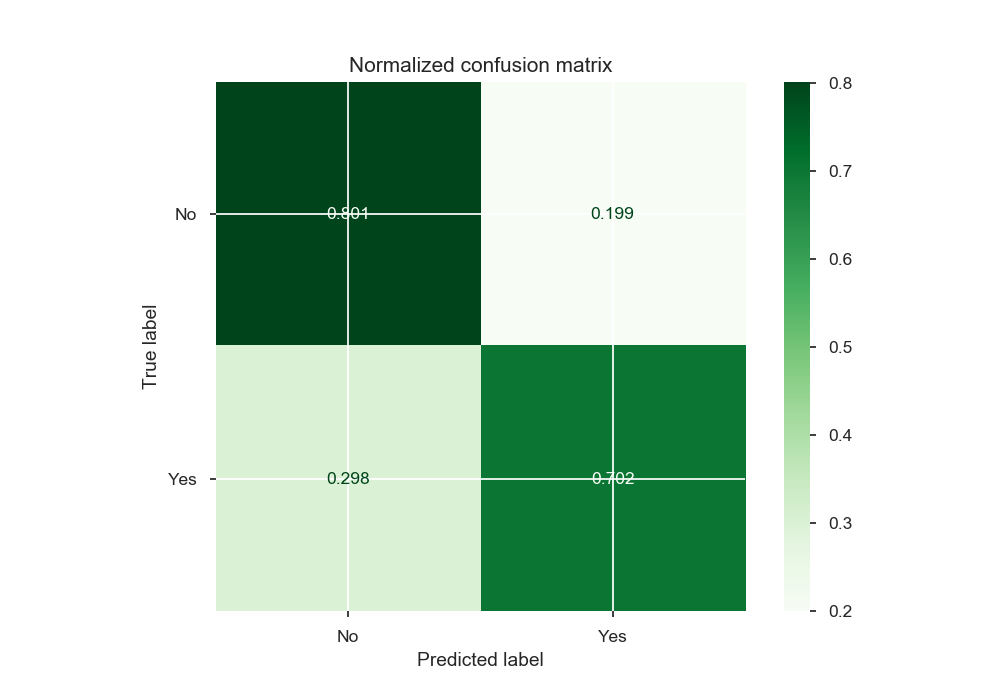

Normalized confusion matrix
[[0.801 0.199]
 [0.298 0.702]]


In [231]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

class_names = sorted(df['Attrition'].unique())
np.set_printoptions(precision=3) 
disp = plot_confusion_matrix(lsvc, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Greens,
                             normalize='true',
                             values_format='.3g')
disp.ax_.set_title("Normalized confusion matrix")

print("Normalized confusion matrix")
print(disp.confusion_matrix)

# fig.tight_layout(pad=3)

os.makedirs('plots', exist_ok=True)
plt.savefig('plots/ConfusionMatrix.png')


Now let's get a Precision-Recall Plot going

Average precision-recall score: 0.61


<IPython.core.display.Javascript object>


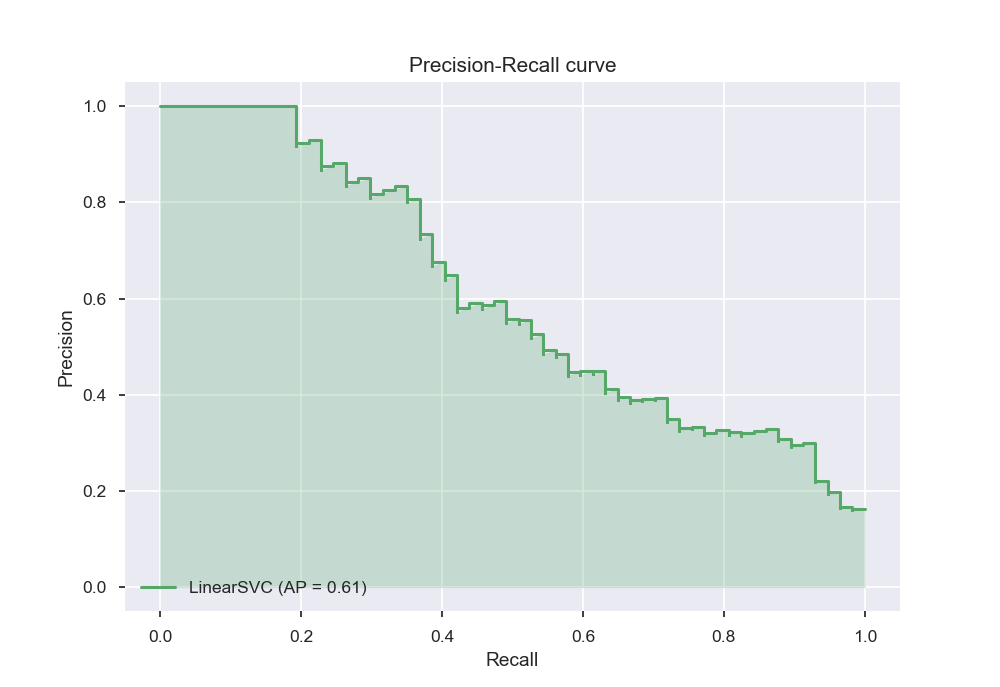

In [233]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import cm

y_score = lsvc.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(lsvc, X_test, y_test, color='g')
x_data = disp.line_.get_xdata()
y_data = disp.line_.get_ydata()
disp.ax_.fill_between(x_data, y_data, alpha=0.25, color='g')
disp.ax_.set_title(f'Precision-Recall curve')
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/Precision-Recall_curve.png')